### Imports

In [1]:
# include pytorch
import torch

# load dataset
import torchvision

# plot images
import matplotlib.pyplot as plt

# tabulate results of grid run
import pandas as pd

# for random normal choice for sampling
import numpy as np 

# import for looking at batch progress
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(0)

# Set desired number of samples per class
desired_samples = 1000

# Set desired batch size
batch_size = 100  

# set total number of epochs
num_epochs = 80

### Get Dataset

In [3]:
# create a custom transform that takes in an image and normalizes it to have 0 mean and 1 variance
class PerImageNormalize(torchvision.transforms.ToTensor):
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = tensor.reshape(-1,784)
        tensor = (tensor - torch.mean(tensor, axis=1, keepdims=True)) / (torch.std(tensor, axis=1, keepdims=True) + 1e-8)
        return tensor

In [4]:
# add transforms
transforms = torchvision.transforms.Compose([
    PerImageNormalize()
])

# create dataset
train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transforms)

### Visualize 1 sample

5


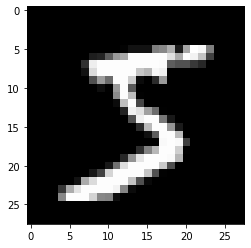

In [5]:
img, label = train_dataset[0]

print(label)
plt.imshow(img.reshape(28,28), cmap='gray')

### Create Dataloaders with sampling

In [6]:
# Create a list to store the indices of the selected samples
selected_indices = []

# Iterate over each unique target class
for class_label in range(10):
    
    # Get the indices of samples belonging to the current class
    class_indices = torch.nonzero(train_dataset.targets == class_label).squeeze()
    
    # Randomly select desired_samples number of samples from the class
    class_indices = torch.from_numpy(np.random.choice(class_indices, desired_samples, replace=False))
    
    # Append the selected indices to the list
    selected_indices.append(class_indices)

# Concatenate the selected indices for all classes
selected_indices = torch.cat(selected_indices)

# Create a SubsetRandomSampler using the selected indices
sampler = torch.utils.data.SubsetRandomSampler(selected_indices)

In [7]:
# Create a DataLoader using the dataset and the sampler
# sampling is only needed for train set
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

### Base Classifier

In [8]:
# Define the model architecture
# Architecture f(x) = softmax(V @ ReLU(W@x))

class MNISTClassifier(torch.nn.Module):
    def __init__(self, input_size, k, output_size, dropout_prob):
        super(MNISTClassifier, self).__init__()
        
        self.fc1 = torch.nn.Linear(input_size, k, bias=False)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.fc2 = torch.nn.Linear(k, output_size, bias=False)

        # Initialize weights with He initialization
        self.initialize_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                # nn.init.constant_(m.bias, 0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

### Training Loop

In [10]:
# Training loop
def train_loop(train_loader, test_loader, n_epochs= 15, k=10, dropout_prob=0.1, lr = 0.001):

    # Initialize the model
    model = MNISTClassifier(784, k, 10, dropout_prob).to(device)

    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []

    # Training loop
    for epoch in range(n_epochs):

        print (f'Epoch : [{epoch}/{n_epochs}]')
        model.train()
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):

            # Move data to device
            data = data.squeeze(1)
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch == 0 or epoch+1 == n_epochs or epoch % 5 == 0:
            # Evaluation on the test set
            model.eval()
            with torch.no_grad():
                
                correct = 0
                total = 0
                for data, targets in train_loader:
                    
                    data = data.squeeze(1)
                    data = data.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(data)
                    loss = criterion(outputs, targets)

                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

                print(f"Accuracy on the train set: {(100 * correct / total):.2f}%, Train Loss: {loss.item():.4f}")
                train_loss_list.append(loss.item())
                train_acc_list.append((100 * correct / total))

                # Evaluation on the test set
                correct = 0
                total = 0
                for data, targets in test_loader:

                    data = data.squeeze(1)
                    data = data.to(device)
                    targets = targets.to(device)

                    outputs = model(data)
                    loss = criterion(outputs, targets)

                    _, predicted = torch.max(outputs.data, 1)
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

                print(f"Accuracy on the test set: {(100 * correct / total):.2f}%, Test Loss: {loss.item():.4f}\n")
                test_loss_list.append(loss.item())
                test_acc_list.append((100 * correct / total))
        
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [11]:
train_loss, test_loss, train_acc, test_acc = train_loop(train_dataloader, 
                                                        test_dataloader, 
                                                        n_epochs=num_epochs, 
                                                        k=40, 
                                                        dropout_prob=0.1, 
                                                        lr=0.001)

Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.51it/s]


Accuracy on the train set: 88.77%, Train Loss: 0.4470
Accuracy on the test set: 88.47%, Test Loss: 0.3581

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.87it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.72it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.95it/s]


Accuracy on the train set: 96.56%, Train Loss: 0.1355
Accuracy on the test set: 94.18%, Test Loss: 0.2001

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.12it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.87it/s]


Accuracy on the train set: 98.00%, Train Loss: 0.0988
Accuracy on the test set: 94.94%, Test Loss: 0.2296

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.21it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.32it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.94it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.23it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.21it/s]


Accuracy on the train set: 99.03%, Train Loss: 0.0743
Accuracy on the test set: 95.54%, Test Loss: 0.2136

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.33it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.42it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.03it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.70it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.58it/s]


Accuracy on the train set: 99.51%, Train Loss: 0.0244
Accuracy on the test set: 95.70%, Test Loss: 0.2416

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.54it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.44it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.64it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.07it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.13it/s]


Accuracy on the train set: 99.64%, Train Loss: 0.0244
Accuracy on the test set: 95.85%, Test Loss: 0.2187

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.78it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.10it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.03it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.26it/s]


Accuracy on the train set: 99.78%, Train Loss: 0.0120
Accuracy on the test set: 95.81%, Test Loss: 0.2406

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.53it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.56it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.46it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.01it/s]


Accuracy on the train set: 99.86%, Train Loss: 0.0124
Accuracy on the test set: 95.84%, Test Loss: 0.2876

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.81it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.82it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.98it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.37it/s]


Accuracy on the train set: 99.96%, Train Loss: 0.0188
Accuracy on the test set: 95.93%, Test Loss: 0.2823

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.04it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.47it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.30it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.94it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.21it/s]


Accuracy on the train set: 99.92%, Train Loss: 0.0121
Accuracy on the test set: 95.72%, Test Loss: 0.2761

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.35it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.26it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.17it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.70it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.26it/s]


Accuracy on the train set: 99.96%, Train Loss: 0.0051
Accuracy on the test set: 95.80%, Test Loss: 0.3427

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.89it/s]


Accuracy on the train set: 99.97%, Train Loss: 0.0048
Accuracy on the test set: 95.87%, Test Loss: 0.3299

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.48it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.54it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.72it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.37it/s]


Accuracy on the train set: 99.98%, Train Loss: 0.0012
Accuracy on the test set: 95.73%, Test Loss: 0.3640

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.85it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


Accuracy on the train set: 99.98%, Train Loss: 0.0111
Accuracy on the test set: 95.82%, Test Loss: 0.3221

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.43it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.20it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.03it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.43it/s]


Accuracy on the train set: 99.98%, Train Loss: 0.0015
Accuracy on the test set: 95.86%, Test Loss: 0.3371

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.63it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.85it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.14it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.62it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.02it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0016
Accuracy on the test set: 95.78%, Test Loss: 0.3842

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.70it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.17it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.10it/s]


Accuracy on the train set: 99.92%, Train Loss: 0.0040
Accuracy on the test set: 95.69%, Test Loss: 0.3828



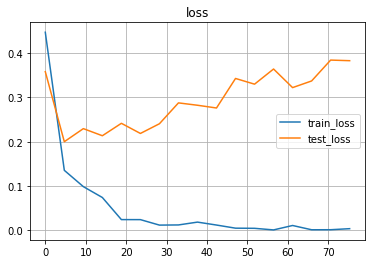

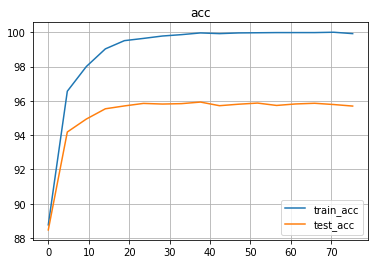

In [12]:
def plot_list(l1,l1_title, l2,l2_title, plt_title):
    plt.figure(1)
    plt.title(plt_title)
    plt.plot(torch.arange(0,num_epochs,num_epochs/len(l1)), l1, label=l1_title)
    plt.plot(torch.arange(0,num_epochs,num_epochs/len(l2)), l2, label=l2_title)
    plt.legend()
    plt.grid()
    plt.show()

plot_list(train_loss,'train_loss', test_loss,'test_loss', 'loss')
plot_list(train_acc,'train_acc', test_acc,'test_acc', 'acc')

### Grid Run

------ for k = 1 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.85it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.96it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.76it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.71it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.61it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.36it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.52it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.86it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.52it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.89it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.65it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.67it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.80it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.44it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.52it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.50it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.37it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.12it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.00it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.75it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.88it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.60it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.08it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.14it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.18it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.09it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.95it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.94it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.83it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.93it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.34it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.24it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.02it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.20it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.39it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.42it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.42it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.01it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.22it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.48it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.34it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.32it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.49it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.93it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.35it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.57it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.57it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.26it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.05it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.37it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.69it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.66it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.49it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.64it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.82it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.86it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.83it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.16it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.77it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.99it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026



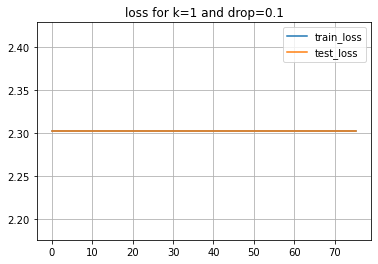

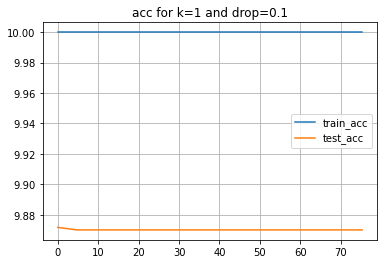

------ for k = 1 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.22it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.28it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.86it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.88it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.57it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.59it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.69it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.43it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.13it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.91it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.54it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.33it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.18it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.04it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.17it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.19it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.98it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.01it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.16it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.56it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.60it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.49it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.56it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.83it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.78it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.13it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.87it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.83it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.65it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.77it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.53it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.88it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.66it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.16it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.82it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.57it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.07it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.87it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.91it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.00it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.28it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.46it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026



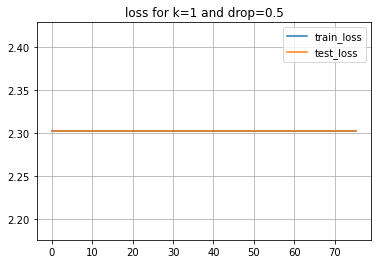

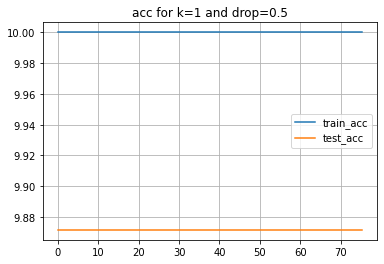

------ for k = 1 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.96it/s]


Accuracy on the train set: 10.34%, Train Loss: 2.2761
Accuracy on the test set: 10.16%, Test Loss: 2.3041

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.54it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.13it/s]


Accuracy on the train set: 19.79%, Train Loss: 2.0476
Accuracy on the test set: 20.77%, Test Loss: 2.0642

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.60it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.15it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.38it/s]


Accuracy on the train set: 19.74%, Train Loss: 2.0797
Accuracy on the test set: 20.73%, Test Loss: 2.0498

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.46it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.79it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.23it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.75it/s]


Accuracy on the train set: 19.80%, Train Loss: 2.0348
Accuracy on the test set: 20.83%, Test Loss: 2.0383

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.38it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.49it/s]


Accuracy on the train set: 19.79%, Train Loss: 2.0808
Accuracy on the test set: 20.75%, Test Loss: 2.0368

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.50it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.57it/s]


Accuracy on the train set: 19.79%, Train Loss: 2.1082
Accuracy on the test set: 20.78%, Test Loss: 2.0501

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.06it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.14it/s]


Accuracy on the train set: 19.81%, Train Loss: 2.0389
Accuracy on the test set: 20.80%, Test Loss: 2.0355

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.35it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.63it/s]


Accuracy on the train set: 19.80%, Train Loss: 2.0278
Accuracy on the test set: 20.81%, Test Loss: 2.0340

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.10it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.96it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.08it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.65it/s]


Accuracy on the train set: 19.82%, Train Loss: 1.9504
Accuracy on the test set: 20.82%, Test Loss: 2.0298

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.58it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.55it/s]


Accuracy on the train set: 19.79%, Train Loss: 2.0008
Accuracy on the test set: 20.80%, Test Loss: 2.0269

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.41it/s]


Accuracy on the train set: 19.78%, Train Loss: 2.0703
Accuracy on the test set: 20.81%, Test Loss: 1.9962

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.09it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Accuracy on the train set: 19.81%, Train Loss: 1.9074
Accuracy on the test set: 20.81%, Test Loss: 2.0044

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.53it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.97it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.94it/s]


Accuracy on the train set: 19.83%, Train Loss: 2.0627
Accuracy on the test set: 20.82%, Test Loss: 2.0149

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.55it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.02it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.02it/s]


Accuracy on the train set: 19.83%, Train Loss: 2.0301
Accuracy on the test set: 20.84%, Test Loss: 2.0149

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.81it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.82it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.42it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.69it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.86it/s]


Accuracy on the train set: 19.82%, Train Loss: 1.9791
Accuracy on the test set: 20.79%, Test Loss: 2.0125

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.35it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.86it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.01it/s]


Accuracy on the train set: 19.77%, Train Loss: 1.9997
Accuracy on the test set: 20.71%, Test Loss: 2.0362

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.89it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.49it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.25it/s]


Accuracy on the train set: 19.82%, Train Loss: 2.0328
Accuracy on the test set: 20.77%, Test Loss: 2.0314



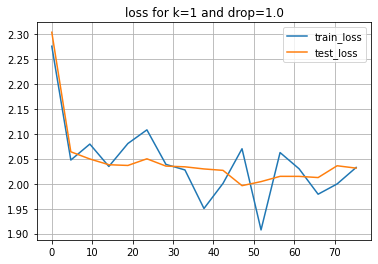

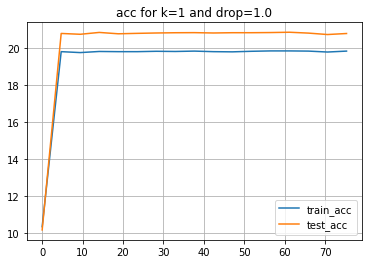

------ for k = 5 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.66it/s]


Accuracy on the train set: 10.10%, Train Loss: 2.2997
Accuracy on the test set: 9.96%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.30it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.13it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.90it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.69it/s]


Accuracy on the train set: 10.08%, Train Loss: 2.3026
Accuracy on the test set: 9.97%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.02it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.41it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.16it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.00it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.22it/s]


Accuracy on the train set: 10.06%, Train Loss: 2.3026
Accuracy on the test set: 9.94%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.72it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.79it/s]


Accuracy on the train set: 10.05%, Train Loss: 2.3026
Accuracy on the test set: 9.93%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.83it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.26it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.14it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.73it/s]


Accuracy on the train set: 10.58%, Train Loss: 2.2920
Accuracy on the test set: 10.44%, Test Loss: 2.2971

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.18it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.55it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.25it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.25it/s]


Accuracy on the train set: 10.05%, Train Loss: 2.3026
Accuracy on the test set: 9.91%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.03it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.41it/s]


Accuracy on the train set: 10.27%, Train Loss: 2.3026
Accuracy on the test set: 10.10%, Test Loss: 2.2934

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.53it/s]


Accuracy on the train set: 11.47%, Train Loss: 2.2539
Accuracy on the test set: 11.18%, Test Loss: 2.2044

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.93it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.62it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.77it/s]


Accuracy on the train set: 11.89%, Train Loss: 2.2876
Accuracy on the test set: 11.61%, Test Loss: 2.1874

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.81it/s]


Accuracy on the train set: 12.37%, Train Loss: 2.2493
Accuracy on the test set: 12.05%, Test Loss: 2.1940

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.54it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.68it/s]


Accuracy on the train set: 12.95%, Train Loss: 2.2893
Accuracy on the test set: 12.58%, Test Loss: 2.1887

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.01it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.48it/s]


Accuracy on the train set: 14.93%, Train Loss: 2.2505
Accuracy on the test set: 14.26%, Test Loss: 2.1777

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.48it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.27it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.90it/s]


Accuracy on the train set: 16.35%, Train Loss: 2.1587
Accuracy on the test set: 15.61%, Test Loss: 2.1451

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.80it/s]


Accuracy on the train set: 16.49%, Train Loss: 2.2049
Accuracy on the test set: 15.70%, Test Loss: 2.1654

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.98it/s]


Accuracy on the train set: 16.80%, Train Loss: 2.2206
Accuracy on the test set: 15.97%, Test Loss: 2.1478

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.65it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.76it/s]


Accuracy on the train set: 16.95%, Train Loss: 2.2044
Accuracy on the test set: 16.11%, Test Loss: 2.1737

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.51it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.80it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.51it/s]


Accuracy on the train set: 16.30%, Train Loss: 2.2480
Accuracy on the test set: 15.53%, Test Loss: 2.1760



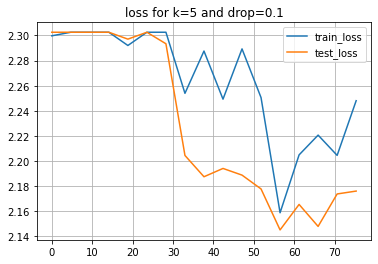

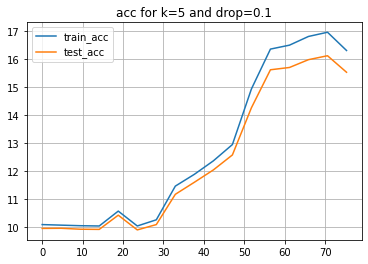

------ for k = 5 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.80it/s]


Accuracy on the train set: 28.80%, Train Loss: 2.0639
Accuracy on the test set: 28.98%, Test Loss: 2.0929

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.84it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Accuracy on the train set: 42.68%, Train Loss: 1.6617
Accuracy on the test set: 43.53%, Test Loss: 1.5848

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.45it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.13it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.35it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.30it/s]


Accuracy on the train set: 54.09%, Train Loss: 1.3429
Accuracy on the test set: 54.90%, Test Loss: 1.3412

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.16it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.34it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.82it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.09it/s]


Accuracy on the train set: 58.13%, Train Loss: 1.2768
Accuracy on the test set: 58.53%, Test Loss: 1.2413

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.74it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.64it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.40it/s]


Accuracy on the train set: 62.61%, Train Loss: 1.1074
Accuracy on the test set: 63.11%, Test Loss: 1.1475

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.53it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.85it/s]


Accuracy on the train set: 64.31%, Train Loss: 1.1550
Accuracy on the test set: 64.36%, Test Loss: 1.1830

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.50it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.13it/s]


Accuracy on the train set: 64.39%, Train Loss: 1.1908
Accuracy on the test set: 64.57%, Test Loss: 1.1290

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.94it/s]


Accuracy on the train set: 64.48%, Train Loss: 1.1821
Accuracy on the test set: 64.85%, Test Loss: 1.1182

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.41it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.17it/s]


Accuracy on the train set: 66.01%, Train Loss: 1.1473
Accuracy on the test set: 65.60%, Test Loss: 1.1829

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.79it/s]


Accuracy on the train set: 68.85%, Train Loss: 1.0921
Accuracy on the test set: 68.32%, Test Loss: 1.0891

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.86it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.56it/s]


Accuracy on the train set: 70.33%, Train Loss: 1.0393
Accuracy on the test set: 69.84%, Test Loss: 1.0719

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.46it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.10it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.93it/s]


Accuracy on the train set: 70.30%, Train Loss: 0.9633
Accuracy on the test set: 69.54%, Test Loss: 0.9948

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.72it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.70it/s]


Accuracy on the train set: 70.21%, Train Loss: 0.8414
Accuracy on the test set: 69.61%, Test Loss: 1.1023

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.85it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.64it/s]


Accuracy on the train set: 69.81%, Train Loss: 1.1746
Accuracy on the test set: 68.65%, Test Loss: 1.0297

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.98it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.90it/s]


Accuracy on the train set: 70.36%, Train Loss: 0.9443
Accuracy on the test set: 69.22%, Test Loss: 1.0386

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.20it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.61it/s]


Accuracy on the train set: 70.57%, Train Loss: 1.0787
Accuracy on the test set: 69.43%, Test Loss: 1.0090

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.60it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.35it/s]


Accuracy on the train set: 70.89%, Train Loss: 0.9194
Accuracy on the test set: 69.83%, Test Loss: 1.0256



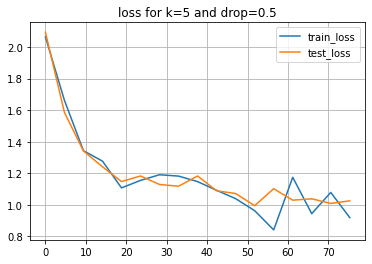

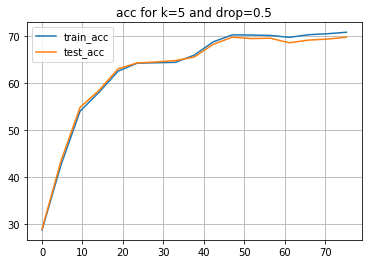

------ for k = 5 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.15it/s]


Accuracy on the train set: 36.78%, Train Loss: 1.5996
Accuracy on the test set: 37.38%, Test Loss: 1.7256

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.79it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.80it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.72it/s]


Accuracy on the train set: 69.26%, Train Loss: 1.0768
Accuracy on the test set: 69.27%, Test Loss: 0.8915

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.96it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.59it/s]


Accuracy on the train set: 80.78%, Train Loss: 0.7250
Accuracy on the test set: 79.92%, Test Loss: 0.5751

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.88it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.20it/s]


Accuracy on the train set: 84.99%, Train Loss: 0.3808
Accuracy on the test set: 83.47%, Test Loss: 0.4990

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.26it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.49it/s]


Accuracy on the train set: 86.04%, Train Loss: 0.6616
Accuracy on the test set: 84.06%, Test Loss: 0.5359

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.07it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.68it/s]


Accuracy on the train set: 86.54%, Train Loss: 0.4104
Accuracy on the test set: 84.38%, Test Loss: 0.5136

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.53it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.47it/s]


Accuracy on the train set: 86.79%, Train Loss: 0.3154
Accuracy on the test set: 84.52%, Test Loss: 0.5060

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.26it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]


Accuracy on the train set: 87.43%, Train Loss: 0.6158
Accuracy on the test set: 84.50%, Test Loss: 0.5708

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.27it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.06it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.95it/s]


Accuracy on the train set: 88.08%, Train Loss: 0.3921
Accuracy on the test set: 85.09%, Test Loss: 0.5351

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.60it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.74it/s]


Accuracy on the train set: 88.03%, Train Loss: 0.4783
Accuracy on the test set: 85.05%, Test Loss: 0.5496

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.31it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.11it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.49it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.53it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.15it/s]


Accuracy on the train set: 88.64%, Train Loss: 0.5126
Accuracy on the test set: 85.21%, Test Loss: 0.5494

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.44it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.84it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.93it/s]


Accuracy on the train set: 88.67%, Train Loss: 0.4725
Accuracy on the test set: 85.25%, Test Loss: 0.5583

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.29it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.62it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.20it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.56it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]


Accuracy on the train set: 88.78%, Train Loss: 0.3275
Accuracy on the test set: 85.05%, Test Loss: 0.5591

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.30it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.38it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.03it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.56it/s]


Accuracy on the train set: 89.04%, Train Loss: 0.3789
Accuracy on the test set: 85.18%, Test Loss: 0.5747

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.73it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.54it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.68it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.43it/s]


Accuracy on the train set: 88.93%, Train Loss: 0.2835
Accuracy on the test set: 84.89%, Test Loss: 0.6081

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.05it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.23it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.25it/s]


Accuracy on the train set: 89.46%, Train Loss: 0.2390
Accuracy on the test set: 85.31%, Test Loss: 0.5748

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.25it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.52it/s]


Accuracy on the train set: 89.19%, Train Loss: 0.2842
Accuracy on the test set: 84.84%, Test Loss: 0.6402



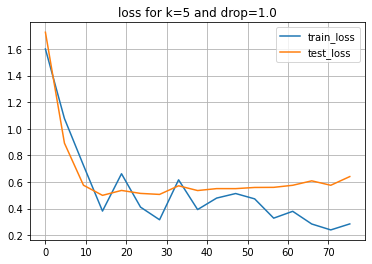

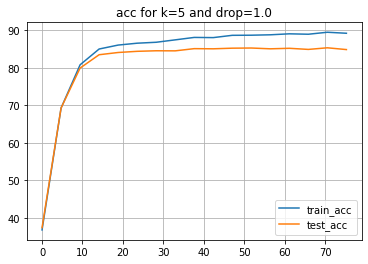

------ for k = 10 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Accuracy on the train set: 19.53%, Train Loss: 2.2661
Accuracy on the test set: 20.54%, Test Loss: 2.2426

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.87it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.74it/s]


Accuracy on the train set: 19.79%, Train Loss: 2.1557
Accuracy on the test set: 20.81%, Test Loss: 2.1690

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.51it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.48it/s]


Accuracy on the train set: 19.84%, Train Loss: 2.1566
Accuracy on the test set: 20.85%, Test Loss: 2.1550

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.38it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


Accuracy on the train set: 30.00%, Train Loss: 1.8249
Accuracy on the test set: 31.32%, Test Loss: 2.0683

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.47it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.64it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.67it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.53it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.42it/s]


Accuracy on the train set: 33.44%, Train Loss: 1.9267
Accuracy on the test set: 34.88%, Test Loss: 1.9489

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.96it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.98it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.62it/s]


Accuracy on the train set: 34.38%, Train Loss: 1.8204
Accuracy on the test set: 34.95%, Test Loss: 1.8962

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.22it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.73it/s]


Accuracy on the train set: 36.14%, Train Loss: 1.6287
Accuracy on the test set: 37.26%, Test Loss: 1.8336

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.39it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.15it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.33it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]


Accuracy on the train set: 36.94%, Train Loss: 1.6356
Accuracy on the test set: 38.15%, Test Loss: 1.8120

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.84it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.54it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.24it/s]


Accuracy on the train set: 36.76%, Train Loss: 1.7446
Accuracy on the test set: 38.08%, Test Loss: 1.7749

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.16it/s]


Accuracy on the train set: 36.87%, Train Loss: 1.8316
Accuracy on the test set: 38.04%, Test Loss: 1.7882

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.70it/s]


Accuracy on the train set: 36.47%, Train Loss: 1.6414
Accuracy on the test set: 37.61%, Test Loss: 1.8123

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.19it/s]


Accuracy on the train set: 36.38%, Train Loss: 1.7115
Accuracy on the test set: 37.47%, Test Loss: 1.7954

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.65it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


Accuracy on the train set: 37.24%, Train Loss: 1.6042
Accuracy on the test set: 38.41%, Test Loss: 1.7456

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.25it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.16it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.36it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.41it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.66it/s]


Accuracy on the train set: 37.37%, Train Loss: 1.6824
Accuracy on the test set: 38.52%, Test Loss: 1.7054

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.26it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.34it/s]


Accuracy on the train set: 44.17%, Train Loss: 1.8627
Accuracy on the test set: 45.34%, Test Loss: 1.7743

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.89it/s]


Accuracy on the train set: 49.53%, Train Loss: 1.6558
Accuracy on the test set: 50.71%, Test Loss: 1.7194

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.47it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.81it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.49it/s]


Accuracy on the train set: 46.49%, Train Loss: 1.6189
Accuracy on the test set: 47.60%, Test Loss: 1.6880



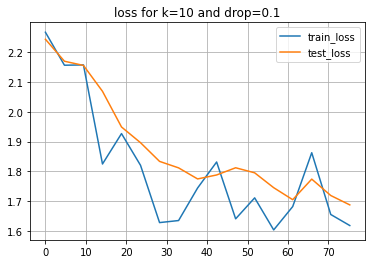

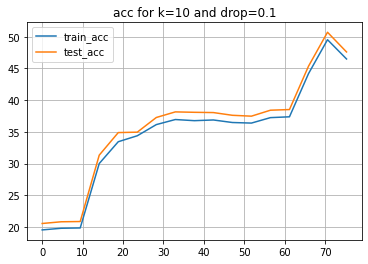

------ for k = 10 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


Accuracy on the train set: 49.73%, Train Loss: 1.5018
Accuracy on the test set: 48.82%, Test Loss: 1.6458

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.61it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.31it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


Accuracy on the train set: 85.13%, Train Loss: 0.7316
Accuracy on the test set: 84.22%, Test Loss: 0.6687

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.97it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.17it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.20it/s]


Accuracy on the train set: 88.64%, Train Loss: 0.5322
Accuracy on the test set: 87.24%, Test Loss: 0.4520

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.68it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.91it/s]


Accuracy on the train set: 89.67%, Train Loss: 0.5553
Accuracy on the test set: 88.09%, Test Loss: 0.4523

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.26it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.41it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.04it/s]


Accuracy on the train set: 89.76%, Train Loss: 0.6020
Accuracy on the test set: 88.15%, Test Loss: 0.4651

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.49it/s]


Accuracy on the train set: 90.55%, Train Loss: 0.3410
Accuracy on the test set: 88.54%, Test Loss: 0.4162

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.90it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.26it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.89it/s]


Accuracy on the train set: 90.72%, Train Loss: 0.4927
Accuracy on the test set: 88.52%, Test Loss: 0.4146

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.26it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.88it/s]


Accuracy on the train set: 91.11%, Train Loss: 0.4410
Accuracy on the test set: 88.94%, Test Loss: 0.4080

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.58it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.46it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.19it/s]


Accuracy on the train set: 91.13%, Train Loss: 0.3360
Accuracy on the test set: 88.56%, Test Loss: 0.3892

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.65it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.16it/s]


Accuracy on the train set: 91.89%, Train Loss: 0.3671
Accuracy on the test set: 89.10%, Test Loss: 0.3919

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.63it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.46it/s]


Accuracy on the train set: 91.93%, Train Loss: 0.3629
Accuracy on the test set: 89.01%, Test Loss: 0.3925

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.02it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.44it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.74it/s]


Accuracy on the train set: 91.87%, Train Loss: 0.4200
Accuracy on the test set: 88.88%, Test Loss: 0.3942

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.06it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.61it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.99it/s]


Accuracy on the train set: 92.00%, Train Loss: 0.3374
Accuracy on the test set: 89.10%, Test Loss: 0.4010

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.00it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.49it/s]


Accuracy on the train set: 92.67%, Train Loss: 0.3255
Accuracy on the test set: 89.35%, Test Loss: 0.4167

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.44it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.46it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.92it/s]


Accuracy on the train set: 92.57%, Train Loss: 0.4207
Accuracy on the test set: 89.40%, Test Loss: 0.4117

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.02it/s]


Accuracy on the train set: 92.20%, Train Loss: 0.4391
Accuracy on the test set: 89.10%, Test Loss: 0.4047

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.86it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.48it/s]


Accuracy on the train set: 92.66%, Train Loss: 0.2899
Accuracy on the test set: 89.43%, Test Loss: 0.4000



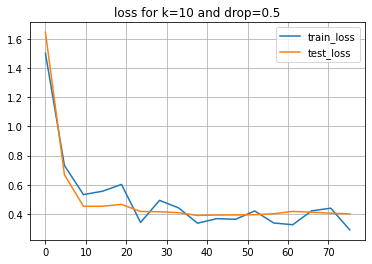

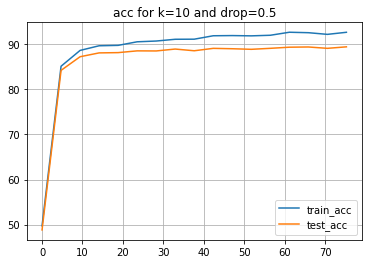

------ for k = 10 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.64it/s]


Accuracy on the train set: 81.28%, Train Loss: 0.6242
Accuracy on the test set: 81.70%, Test Loss: 0.6965

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.13it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.26it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.90it/s]


Accuracy on the train set: 91.83%, Train Loss: 0.2250
Accuracy on the test set: 90.51%, Test Loss: 0.2596

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.84it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.30it/s]


Accuracy on the train set: 93.69%, Train Loss: 0.2568
Accuracy on the test set: 91.46%, Test Loss: 0.2293

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.65it/s]


Accuracy on the train set: 94.69%, Train Loss: 0.2027
Accuracy on the test set: 91.77%, Test Loss: 0.2358

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.82it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.74it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.68it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.17it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.15it/s]


Accuracy on the train set: 95.53%, Train Loss: 0.1854
Accuracy on the test set: 91.91%, Test Loss: 0.2359

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.96it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.20it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.57it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.68it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.17it/s]


Accuracy on the train set: 96.09%, Train Loss: 0.2261
Accuracy on the test set: 92.21%, Test Loss: 0.2107

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.52it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.33it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.79it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.88it/s]


Accuracy on the train set: 96.59%, Train Loss: 0.0801
Accuracy on the test set: 92.11%, Test Loss: 0.2168

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.04it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.77it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.15it/s]


Accuracy on the train set: 96.74%, Train Loss: 0.1282
Accuracy on the test set: 92.11%, Test Loss: 0.2400

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.25it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.53it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.20it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.14it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.10it/s]


Accuracy on the train set: 97.33%, Train Loss: 0.1527
Accuracy on the test set: 92.15%, Test Loss: 0.1900

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.51it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.44it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.62it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.97it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.35it/s]


Accuracy on the train set: 97.39%, Train Loss: 0.0500
Accuracy on the test set: 91.94%, Test Loss: 0.2164

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.36it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.08it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.02it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.29it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.38it/s]


Accuracy on the train set: 97.72%, Train Loss: 0.0685
Accuracy on the test set: 92.11%, Test Loss: 0.2504

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.54it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.09it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.95it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.05it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.99it/s]


Accuracy on the train set: 98.21%, Train Loss: 0.0358
Accuracy on the test set: 92.14%, Test Loss: 0.2167

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.77it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.99it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.51it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.38it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.36it/s]


Accuracy on the train set: 98.04%, Train Loss: 0.0285
Accuracy on the test set: 91.84%, Test Loss: 0.2582

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.63it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.51it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.33it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.40it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.68it/s]


Accuracy on the train set: 98.33%, Train Loss: 0.0380
Accuracy on the test set: 91.91%, Test Loss: 0.2862

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.83it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.05it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Accuracy on the train set: 98.52%, Train Loss: 0.0479
Accuracy on the test set: 91.73%, Test Loss: 0.2740

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.04it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.95it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.03it/s]


Accuracy on the train set: 98.71%, Train Loss: 0.0358
Accuracy on the test set: 91.90%, Test Loss: 0.2959

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.47it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.38it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.59it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.73it/s]


Accuracy on the train set: 98.82%, Train Loss: 0.0205
Accuracy on the test set: 91.91%, Test Loss: 0.3255



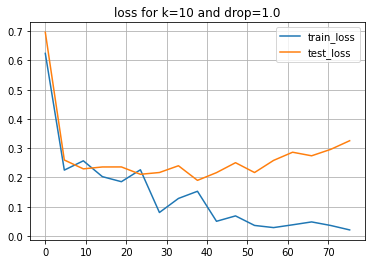

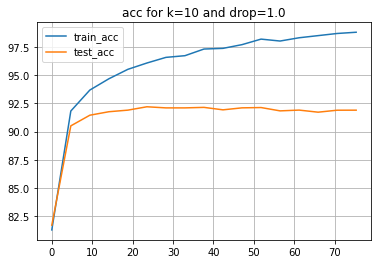

------ for k = 20 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.99it/s]


Accuracy on the train set: 16.18%, Train Loss: 2.2670
Accuracy on the test set: 17.04%, Test Loss: 2.2856

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.58it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.98it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.04it/s]


Accuracy on the train set: 27.78%, Train Loss: 2.0744
Accuracy on the test set: 28.75%, Test Loss: 2.1096

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


Accuracy on the train set: 27.56%, Train Loss: 1.9316
Accuracy on the test set: 28.52%, Test Loss: 2.0309

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.73it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.42it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.90it/s]


Accuracy on the train set: 28.27%, Train Loss: 1.9933
Accuracy on the test set: 29.18%, Test Loss: 1.9560

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.20it/s]


Accuracy on the train set: 28.31%, Train Loss: 1.9688
Accuracy on the test set: 29.16%, Test Loss: 1.9211

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.80it/s]


Accuracy on the train set: 45.82%, Train Loss: 1.8227
Accuracy on the test set: 46.69%, Test Loss: 1.7454

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.44it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.34it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.27it/s]


Accuracy on the train set: 45.96%, Train Loss: 1.6262
Accuracy on the test set: 46.83%, Test Loss: 1.7031

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.03it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.28it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.55it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.57it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.22it/s]


Accuracy on the train set: 54.82%, Train Loss: 1.6039
Accuracy on the test set: 55.86%, Test Loss: 1.5574

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.61it/s]


Accuracy on the train set: 56.20%, Train Loss: 1.4430
Accuracy on the test set: 56.97%, Test Loss: 1.5528

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.12it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.42it/s]


Accuracy on the train set: 47.71%, Train Loss: 1.5133
Accuracy on the test set: 48.66%, Test Loss: 1.5288

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.74it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Accuracy on the train set: 47.29%, Train Loss: 1.4364
Accuracy on the test set: 48.19%, Test Loss: 1.5304

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.17it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.14it/s]


Accuracy on the train set: 51.27%, Train Loss: 1.5782
Accuracy on the test set: 52.26%, Test Loss: 1.4989

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.31it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.26it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.36it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.08it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.34it/s]


Accuracy on the train set: 62.28%, Train Loss: 1.4310
Accuracy on the test set: 63.00%, Test Loss: 1.5038

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.06it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.70it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.38it/s]


Accuracy on the train set: 49.58%, Train Loss: 1.3672
Accuracy on the test set: 50.51%, Test Loss: 1.4816

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.89it/s]


Accuracy on the train set: 49.42%, Train Loss: 1.5980
Accuracy on the test set: 50.18%, Test Loss: 1.4927

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.30it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.45it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.48it/s]


Accuracy on the train set: 56.26%, Train Loss: 1.5587
Accuracy on the test set: 56.57%, Test Loss: 1.4830

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.60it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.78it/s]


Accuracy on the train set: 50.28%, Train Loss: 1.4390
Accuracy on the test set: 51.00%, Test Loss: 1.5150



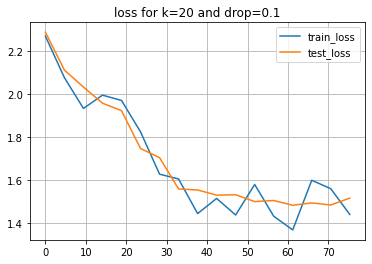

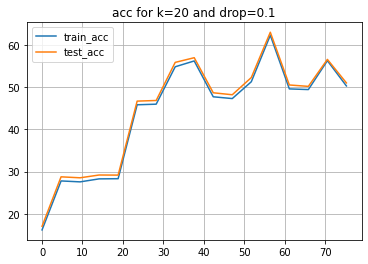

------ for k = 20 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.93it/s]


Accuracy on the train set: 77.96%, Train Loss: 0.9269
Accuracy on the test set: 78.42%, Test Loss: 0.8592

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.72it/s]


Accuracy on the train set: 90.95%, Train Loss: 0.4240
Accuracy on the test set: 90.13%, Test Loss: 0.3068

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.94it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.21it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.27it/s]


Accuracy on the train set: 92.78%, Train Loss: 0.2658
Accuracy on the test set: 91.51%, Test Loss: 0.3044

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.77it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.89it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.50it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.34it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.06it/s]


Accuracy on the train set: 93.22%, Train Loss: 0.2817
Accuracy on the test set: 91.57%, Test Loss: 0.3278

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.08it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.02it/s]


Accuracy on the train set: 93.81%, Train Loss: 0.2245
Accuracy on the test set: 91.87%, Test Loss: 0.3179

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.36it/s]


Accuracy on the train set: 94.14%, Train Loss: 0.2700
Accuracy on the test set: 91.90%, Test Loss: 0.3369

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.43it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.40it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.83it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.13it/s]


Accuracy on the train set: 94.46%, Train Loss: 0.2770
Accuracy on the test set: 91.88%, Test Loss: 0.3223

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


Accuracy on the train set: 94.84%, Train Loss: 0.2082
Accuracy on the test set: 92.08%, Test Loss: 0.3194

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.58it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.39it/s]


Accuracy on the train set: 94.95%, Train Loss: 0.2282
Accuracy on the test set: 92.23%, Test Loss: 0.3053

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.19it/s]


Accuracy on the train set: 95.12%, Train Loss: 0.1880
Accuracy on the test set: 92.23%, Test Loss: 0.2743

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.61it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.83it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.98it/s]


Accuracy on the train set: 95.32%, Train Loss: 0.2089
Accuracy on the test set: 92.38%, Test Loss: 0.2575

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.65it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.10it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.28it/s]


Accuracy on the train set: 95.45%, Train Loss: 0.1337
Accuracy on the test set: 92.22%, Test Loss: 0.3238

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.80it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.96it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.99it/s]


Accuracy on the train set: 95.79%, Train Loss: 0.1201
Accuracy on the test set: 92.51%, Test Loss: 0.2961

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.92it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.83it/s]


Accuracy on the train set: 95.86%, Train Loss: 0.0816
Accuracy on the test set: 92.42%, Test Loss: 0.3179

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.66it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.63it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.26it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.70it/s]


Accuracy on the train set: 96.10%, Train Loss: 0.1796
Accuracy on the test set: 92.45%, Test Loss: 0.2927

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.41it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.18it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.98it/s]


Accuracy on the train set: 96.19%, Train Loss: 0.1030
Accuracy on the test set: 92.45%, Test Loss: 0.2889

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.79it/s]


Accuracy on the train set: 96.21%, Train Loss: 0.1293
Accuracy on the test set: 92.48%, Test Loss: 0.2955



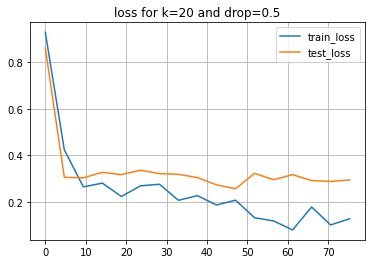

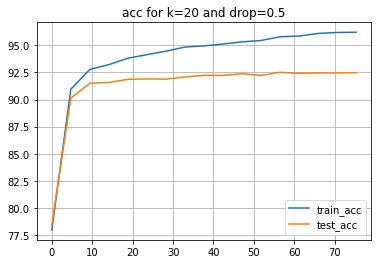

------ for k = 20 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.80it/s]


Accuracy on the train set: 86.04%, Train Loss: 0.6011
Accuracy on the test set: 85.87%, Test Loss: 0.5049

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.33it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.40it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.73it/s]


Accuracy on the train set: 94.66%, Train Loss: 0.2778
Accuracy on the test set: 92.40%, Test Loss: 0.2259

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.38it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.57it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.54it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.01it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Accuracy on the train set: 96.64%, Train Loss: 0.0842
Accuracy on the test set: 93.30%, Test Loss: 0.2401

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.01it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.00it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.68it/s]


Accuracy on the train set: 97.93%, Train Loss: 0.0565
Accuracy on the test set: 93.92%, Test Loss: 0.2273

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.84it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.05it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Accuracy on the train set: 98.41%, Train Loss: 0.0941
Accuracy on the test set: 93.97%, Test Loss: 0.2434

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 98.93%, Train Loss: 0.0493
Accuracy on the test set: 94.17%, Test Loss: 0.2237

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.86it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.89it/s]


Accuracy on the train set: 99.37%, Train Loss: 0.0284
Accuracy on the test set: 94.18%, Test Loss: 0.2699

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.08it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Accuracy on the train set: 99.75%, Train Loss: 0.0120
Accuracy on the test set: 94.42%, Test Loss: 0.2403

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.11it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.89it/s]


Accuracy on the train set: 99.91%, Train Loss: 0.0160
Accuracy on the test set: 94.44%, Test Loss: 0.2440

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.79it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.62it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.94it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0058
Accuracy on the test set: 94.45%, Test Loss: 0.2778

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 99.99%, Train Loss: 0.0091
Accuracy on the test set: 94.44%, Test Loss: 0.2732

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.77it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.62it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0027
Accuracy on the test set: 94.38%, Test Loss: 0.2797

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.38it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.57it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.23it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0056
Accuracy on the test set: 94.34%, Test Loss: 0.2886

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.41it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.71it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0025
Accuracy on the test set: 94.47%, Test Loss: 0.2941

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0017
Accuracy on the test set: 94.51%, Test Loss: 0.3192

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.97it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.39it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0013
Accuracy on the test set: 94.41%, Test Loss: 0.3096

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.84it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0008
Accuracy on the test set: 94.45%, Test Loss: 0.3293



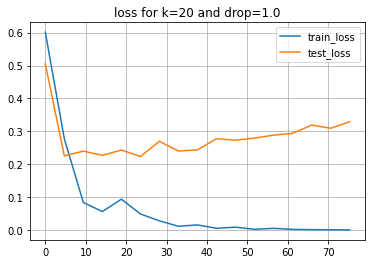

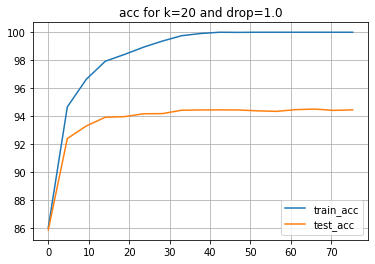

------ for k = 40 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Accuracy on the train set: 33.07%, Train Loss: 2.0897
Accuracy on the test set: 34.29%, Test Loss: 2.0238

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Accuracy on the train set: 72.46%, Train Loss: 1.3211
Accuracy on the test set: 72.76%, Test Loss: 1.3401

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Accuracy on the train set: 76.02%, Train Loss: 1.1197
Accuracy on the test set: 75.84%, Test Loss: 1.0441

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.16it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Accuracy on the train set: 79.51%, Train Loss: 0.9304
Accuracy on the test set: 79.34%, Test Loss: 0.9090

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.81it/s]


Accuracy on the train set: 81.06%, Train Loss: 1.0036
Accuracy on the test set: 80.88%, Test Loss: 0.8610

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Accuracy on the train set: 81.18%, Train Loss: 0.8714
Accuracy on the test set: 81.11%, Test Loss: 0.7997

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.64it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.49it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.09it/s]


Accuracy on the train set: 80.36%, Train Loss: 0.7431
Accuracy on the test set: 80.11%, Test Loss: 0.7701

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Accuracy on the train set: 84.07%, Train Loss: 0.6491
Accuracy on the test set: 83.65%, Test Loss: 0.7127

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Accuracy on the train set: 85.97%, Train Loss: 0.7990
Accuracy on the test set: 85.14%, Test Loss: 0.7538

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Accuracy on the train set: 86.05%, Train Loss: 0.7599
Accuracy on the test set: 85.32%, Test Loss: 0.6986

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.76it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.96it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.00it/s]


Accuracy on the train set: 87.56%, Train Loss: 0.7328
Accuracy on the test set: 86.66%, Test Loss: 0.6847

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Accuracy on the train set: 86.59%, Train Loss: 0.6597
Accuracy on the test set: 85.56%, Test Loss: 0.6804

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.13it/s]


Accuracy on the train set: 88.04%, Train Loss: 0.6251
Accuracy on the test set: 86.82%, Test Loss: 0.6676

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Accuracy on the train set: 87.74%, Train Loss: 0.7672
Accuracy on the test set: 86.45%, Test Loss: 0.6688

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.75it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.24it/s]


Accuracy on the train set: 88.28%, Train Loss: 0.6249
Accuracy on the test set: 86.99%, Test Loss: 0.5964

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.28it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Accuracy on the train set: 87.10%, Train Loss: 0.6378
Accuracy on the test set: 86.11%, Test Loss: 0.6520

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.54it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Accuracy on the train set: 88.22%, Train Loss: 0.6435
Accuracy on the test set: 86.95%, Test Loss: 0.6731



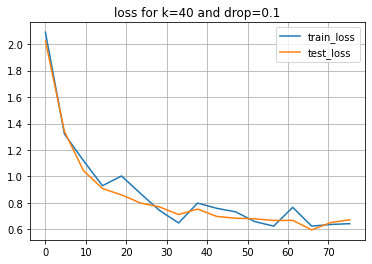

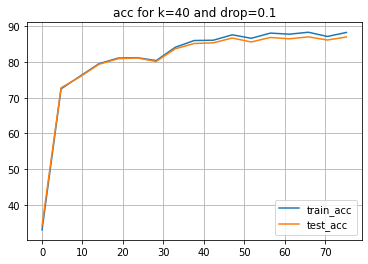

------ for k = 40 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.00it/s]


Accuracy on the train set: 84.30%, Train Loss: 0.6509
Accuracy on the test set: 84.27%, Test Loss: 0.6622

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.04it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Accuracy on the train set: 93.50%, Train Loss: 0.1753
Accuracy on the test set: 92.09%, Test Loss: 0.2390

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.66it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Accuracy on the train set: 95.11%, Train Loss: 0.1869
Accuracy on the test set: 93.09%, Test Loss: 0.2527

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.72it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Accuracy on the train set: 95.99%, Train Loss: 0.1096
Accuracy on the test set: 93.42%, Test Loss: 0.2371

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 96.44%, Train Loss: 0.2206
Accuracy on the test set: 93.76%, Test Loss: 0.2266

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Accuracy on the train set: 97.17%, Train Loss: 0.0497
Accuracy on the test set: 94.11%, Test Loss: 0.2554

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Accuracy on the train set: 97.25%, Train Loss: 0.1152
Accuracy on the test set: 94.21%, Test Loss: 0.2543

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Accuracy on the train set: 97.47%, Train Loss: 0.0370
Accuracy on the test set: 94.10%, Test Loss: 0.2535

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Accuracy on the train set: 98.02%, Train Loss: 0.0931
Accuracy on the test set: 94.45%, Test Loss: 0.2484

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.66it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Accuracy on the train set: 98.20%, Train Loss: 0.0857
Accuracy on the test set: 94.58%, Test Loss: 0.2598

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.73it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Accuracy on the train set: 98.32%, Train Loss: 0.1138
Accuracy on the test set: 94.50%, Test Loss: 0.2985

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Accuracy on the train set: 98.37%, Train Loss: 0.0533
Accuracy on the test set: 94.52%, Test Loss: 0.3314

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Accuracy on the train set: 98.67%, Train Loss: 0.0278
Accuracy on the test set: 94.51%, Test Loss: 0.2893

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Accuracy on the train set: 98.43%, Train Loss: 0.0726
Accuracy on the test set: 94.33%, Test Loss: 0.3623

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Accuracy on the train set: 98.70%, Train Loss: 0.0372
Accuracy on the test set: 94.50%, Test Loss: 0.3673

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Accuracy on the train set: 98.87%, Train Loss: 0.0213
Accuracy on the test set: 94.64%, Test Loss: 0.3573

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Accuracy on the train set: 98.82%, Train Loss: 0.0533
Accuracy on the test set: 94.50%, Test Loss: 0.3142



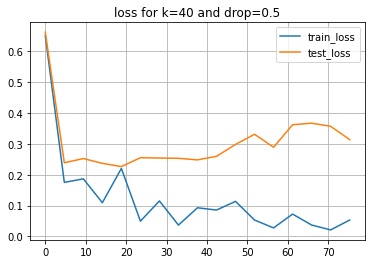

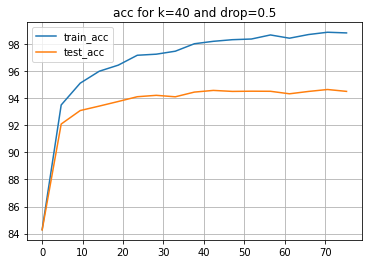

------ for k = 40 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Accuracy on the train set: 89.69%, Train Loss: 0.4834
Accuracy on the test set: 89.16%, Test Loss: 0.3074

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.24it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.17it/s]


Accuracy on the train set: 97.03%, Train Loss: 0.0859
Accuracy on the test set: 94.23%, Test Loss: 0.2032

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.87it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.74it/s]


Accuracy on the train set: 98.50%, Train Loss: 0.0741
Accuracy on the test set: 94.71%, Test Loss: 0.2554

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.91it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.05it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Accuracy on the train set: 99.64%, Train Loss: 0.0135
Accuracy on the test set: 95.52%, Test Loss: 0.2492

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.83it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.73it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.52it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Accuracy on the train set: 99.88%, Train Loss: 0.0124
Accuracy on the test set: 95.50%, Test Loss: 0.2719

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.34it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.22it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0083
Accuracy on the test set: 95.70%, Test Loss: 0.2997

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.95it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.26it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0075
Accuracy on the test set: 95.72%, Test Loss: 0.3294

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.85it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0021
Accuracy on the test set: 95.78%, Test Loss: 0.3510

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0018
Accuracy on the test set: 95.79%, Test Loss: 0.3689

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.18it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0010
Accuracy on the test set: 95.78%, Test Loss: 0.3729

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.07it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0016
Accuracy on the test set: 95.80%, Test Loss: 0.4085

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.61it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0004
Accuracy on the test set: 95.86%, Test Loss: 0.4252

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0007
Accuracy on the test set: 95.78%, Test Loss: 0.4329

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.53it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0002
Accuracy on the test set: 95.86%, Test Loss: 0.4684

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.04it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0003
Accuracy on the test set: 95.84%, Test Loss: 0.4744

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.34it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0002
Accuracy on the test set: 95.86%, Test Loss: 0.4965

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.80it/s]


Accuracy on the train set: 100.00%, Train Loss: 0.0001
Accuracy on the test set: 95.85%, Test Loss: 0.4993



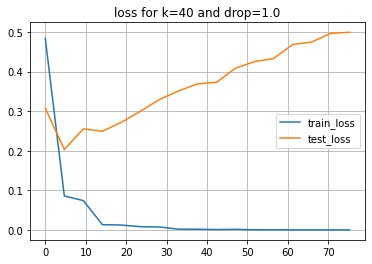

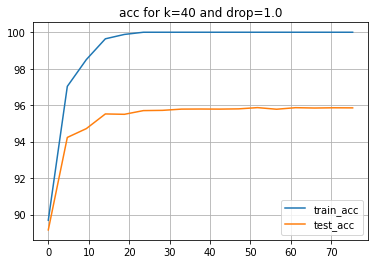

In [13]:
records = []

for k in [1,5,10,20,40]:
    for dropout_prob in [0.1, 0.5, 1.0]:

        print (f'------ for k = {k} and dropout =  {dropout_prob} ---------')
        train_loss, test_loss, train_acc, test_acc = train_loop(train_dataloader, 
                                                                test_dataloader, 
                                                                n_epochs=num_epochs, 
                                                                k=k, 
                                                                dropout_prob=1-dropout_prob, 
                                                                lr=0.001)
        
        plot_list(train_loss,'train_loss', test_loss,'test_loss', f'loss for k={k} and drop={dropout_prob}')
        plot_list(train_acc,'train_acc', test_acc,'test_acc', f'acc for k={k} and drop={dropout_prob}')

        records.append({
            'k':k,
            'dropout_prob':dropout_prob,
            'train_loss':train_loss, 
            'test_loss': test_loss, 
            'train_acc': train_acc, 
            'test_acc': test_acc
        })

In [14]:
records_updated = []

for record in records:
    records_updated.append({
            'k':record['k'],
            'dropout_prob':record['dropout_prob'],
            'train_acc': max(record['train_acc']), 
            'test_acc': max(record['test_acc']), 
        })
df = pd.DataFrame.from_records(records_updated)
df

,k,dropout_prob,train_acc,test_acc
0,1,0.1,10.00,9.871667
1,1,0.5,10.00,9.871667
2,1,1.0,19.83,20.838333
3,5,0.1,16.95,16.113333
4,5,0.5,70.89,69.838333
5,5,1.0,89.46,85.313333
6,10,0.1,49.53,50.706667
7,10,0.5,92.67,89.431667
8,10,1.0,98.82,92.206667
9,20,0.1,62.28,62.998333


### Plot Results

In [15]:
df_tensor = torch.tensor(df.values)
df_tensor

tensor([[  1.0000,   0.1000,  10.0000,   9.8717],
        [  1.0000,   0.5000,  10.0000,   9.8717],
        [  1.0000,   1.0000,  19.8300,  20.8383],
        [  5.0000,   0.1000,  16.9500,  16.1133],
        [  5.0000,   0.5000,  70.8900,  69.8383],
        [  5.0000,   1.0000,  89.4600,  85.3133],
        [ 10.0000,   0.1000,  49.5300,  50.7067],
        [ 10.0000,   0.5000,  92.6700,  89.4317],
        [ 10.0000,   1.0000,  98.8200,  92.2067],
        [ 20.0000,   0.1000,  62.2800,  62.9983],
        [ 20.0000,   0.5000,  96.2100,  92.5117],
        [ 20.0000,   1.0000, 100.0000,  94.5067],
        [ 40.0000,   0.1000,  88.2800,  86.9900],
        [ 40.0000,   0.5000,  98.8700,  94.6417],
        [ 40.0000,   1.0000, 100.0000,  95.8650]], dtype=torch.float64)

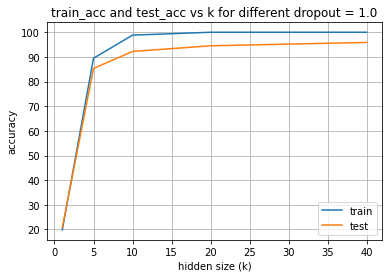

In [16]:
plt.figure(1)
sub_df = df_tensor[df_tensor[:,1] == 1.0]
plt.plot(sub_df[:, 0], sub_df[:,2], label='train')
plt.plot(sub_df[:, 0], sub_df[:,3], label='test')

plt.title('train_acc and test_acc vs k for different dropout = 1.0')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()
plt.show()

As k increases, the accuracy and performance of the model increases and improves.
At at and after 20, we can see that accuracy becomes 100%

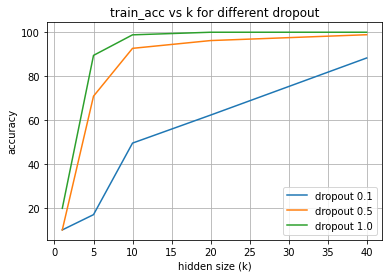

In [17]:
plt.figure(2)
for p in [0.1,0.5, 1.0]:
    sub_df = df_tensor[df_tensor[:,1] == p]
    plt.plot(sub_df[:, 0], sub_df[:,2], label=f'dropout {p}')

plt.title('train_acc vs k for different dropout')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()
plt.show()

The value of p or dropout helps the model generalize and prevents overfitting.

As we increase the value of p, we can see that the model improves and also it is easier to optimize.

At p = 1 we can see 100% train accuracy at k = 20.

At p = 0.5 we can see 100% train accuracy at k = 40.

At p = 0.1 we can see 100% train accuracy at k = 80 if we had run our model for that many hidden units.

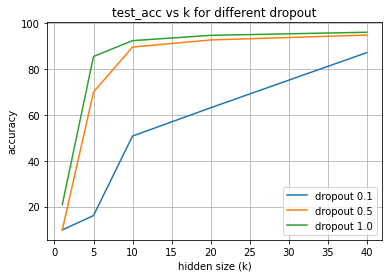

In [18]:
plt.figure(3)
for p in [0.1,0.5, 1.0]:
    sub_df = df_tensor[df_tensor[:,1] == p]
    plt.plot(sub_df[:, 0], sub_df[:,3], label=f'dropout {p}')

plt.title('test_acc vs k for different dropout')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()
plt.show()

We can see a little improvement in test accuracy when we add dropout.

The model converges earlier.

For k = 40 and dropout = 1.0, we can get the best test accuracy

### Create Dataset again and Add Noise

In [19]:
class PerImageNormalize(torchvision.transforms.ToTensor):
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = tensor.reshape(-1,784)
        tensor = (tensor - torch.mean(tensor, axis=1, keepdims=True)) / (torch.std(tensor, axis=1, keepdims=True) + 1e-8)
        return tensor
        
transforms = torchvision.transforms.Compose([
    PerImageNormalize()
])


train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transforms)

In [20]:
def generate_random_numbers(start, end, exclude, num_samples):
    random_nums = []
    while len(random_nums) < num_samples:
        batch_size = num_samples - len(random_nums)
        random_batch = torch.randint(start, end, (batch_size,))
        valid_nums = random_batch[random_batch != exclude]
        random_nums.extend(valid_nums.tolist())
    return torch.tensor(random_nums)

In [21]:
noisy_labels = train_dataset.targets.clone()

# ~40% of examples per label will have their labels changed
noise_ratio = 0.4  


for label in range(10):
    label_indices = torch.where(train_dataset.targets == label)[0]
    sampled_indices = np.random.choice(label_indices, label_indices.shape[0], replace=False)
    noisy_indices = np.random.choice(sampled_indices, int(label_indices.shape[0] * noise_ratio), replace=False)
    new_labels = generate_random_numbers(0, 10, label, (int(label_indices.shape[0] * noise_ratio)))
    noisy_labels[noisy_indices] = new_labels

train_dataset.targets = noisy_labels

### Sample Again

In [22]:
# Create a list to store the indices of the selected samples
selected_indices = []

# Iterate over each unique target class
for class_label in range(10):
    
    # Get the indices of samples belonging to the current class
    class_indices = torch.nonzero(train_dataset.targets == class_label).squeeze()
    
    # Randomly select desired_samples number of samples from the class
    class_indices = torch.from_numpy(np.random.choice(class_indices, desired_samples, replace=False))
    
    # Append the selected indices to the list
    selected_indices.append(class_indices)

# Concatenate the selected indices for all classes
selected_indices = torch.cat(selected_indices)

# Create a SubsetRandomSampler using the selected indices
sampler = torch.utils.data.SubsetRandomSampler(selected_indices)

In [23]:
# Create a DataLoader using the dataset and the sampler
# sampling is only needed for train set
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

### Run Grid Again

------ for k = 1 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.84it/s]


Accuracy on the train set: 9.99%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Accuracy on the train set: 9.99%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.62it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.80it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.05it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.73it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.69it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.72it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.34it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.76it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.54it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.77it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.82it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.37it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.45it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.11it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.38it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026



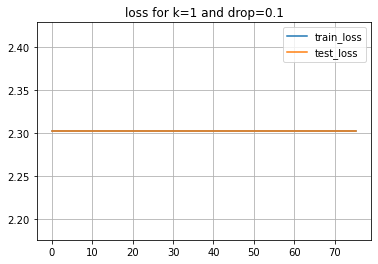

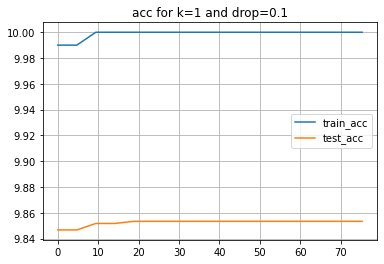

------ for k = 1 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.14it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.11it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.44it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.43it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.03it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.14it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.93it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.40it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.15it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.62it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.28it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.77it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.37it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.66it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.19it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.44it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.56it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.14it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.62it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.59it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026



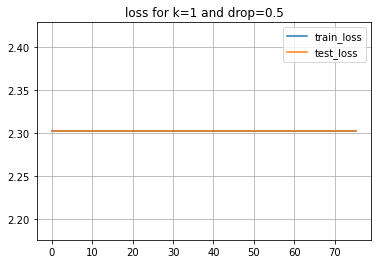

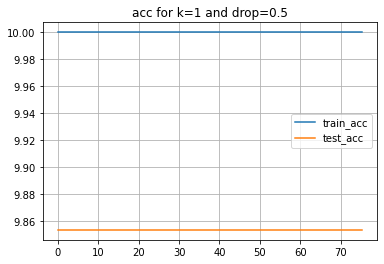

------ for k = 1 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.59it/s]


Accuracy on the train set: 10.04%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.23it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.76it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Accuracy on the train set: 10.24%, Train Loss: 2.3026
Accuracy on the test set: 10.05%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.34it/s]


Accuracy on the train set: 13.66%, Train Loss: 2.2558
Accuracy on the test set: 13.41%, Test Loss: 2.2616

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Accuracy on the train set: 13.87%, Train Loss: 2.2743
Accuracy on the test set: 13.30%, Test Loss: 2.2546

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.69it/s]


Accuracy on the train set: 14.67%, Train Loss: 2.1761
Accuracy on the test set: 14.41%, Test Loss: 2.2655

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.20it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 14.71%, Train Loss: 2.2217
Accuracy on the test set: 14.27%, Test Loss: 2.2632

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.02it/s]


Accuracy on the train set: 15.09%, Train Loss: 2.2871
Accuracy on the test set: 14.79%, Test Loss: 2.2537

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.75it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Accuracy on the train set: 14.84%, Train Loss: 2.2351
Accuracy on the test set: 14.36%, Test Loss: 2.2791

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.50it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.05it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60it/s]


Accuracy on the train set: 15.05%, Train Loss: 2.1964
Accuracy on the test set: 14.58%, Test Loss: 2.2731

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Accuracy on the train set: 15.07%, Train Loss: 2.1987
Accuracy on the test set: 14.77%, Test Loss: 2.2482

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.76it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.79it/s]


Accuracy on the train set: 14.91%, Train Loss: 2.1897
Accuracy on the test set: 14.29%, Test Loss: 2.2630

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Accuracy on the train set: 15.16%, Train Loss: 2.1667
Accuracy on the test set: 14.52%, Test Loss: 2.2570

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.79it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.74it/s]


Accuracy on the train set: 15.06%, Train Loss: 2.1917
Accuracy on the test set: 14.69%, Test Loss: 2.2536

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.71it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.54it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.31it/s]


Accuracy on the train set: 15.15%, Train Loss: 2.2204
Accuracy on the test set: 14.63%, Test Loss: 2.2558

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.64it/s]


Accuracy on the train set: 15.13%, Train Loss: 2.2442
Accuracy on the test set: 14.46%, Test Loss: 2.2605

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Accuracy on the train set: 15.11%, Train Loss: 2.2181
Accuracy on the test set: 14.36%, Test Loss: 2.2648

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Accuracy on the train set: 15.09%, Train Loss: 2.2921
Accuracy on the test set: 14.86%, Test Loss: 2.2615



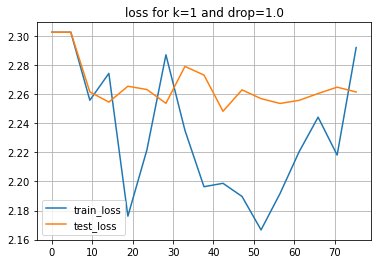

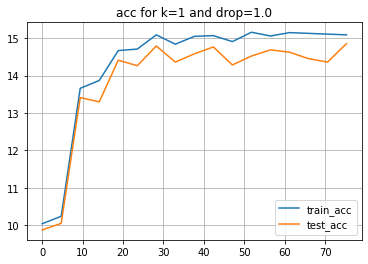

------ for k = 5 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Accuracy on the train set: 9.99%, Train Loss: 2.3023
Accuracy on the test set: 9.89%, Test Loss: 2.3109

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.46it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3024

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.55it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.68it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 10.05%, Train Loss: 2.2995
Accuracy on the test set: 9.90%, Test Loss: 2.3024

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Accuracy on the train set: 9.99%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3017

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.07it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Accuracy on the train set: 9.99%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.69it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.22it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.27it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.63it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.78it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.94it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.82it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.71it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.81it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3025

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.27it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3024

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.63it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.11it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3023

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.86it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3022

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.52it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3022

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.75it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3026
Accuracy on the test set: 9.85%, Test Loss: 2.3022



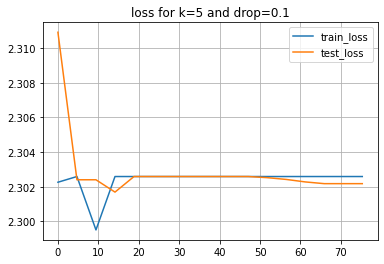

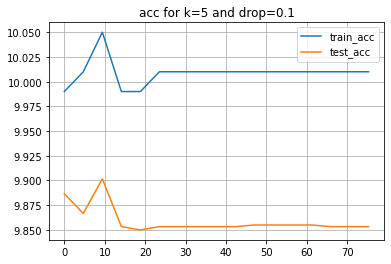

------ for k = 5 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Accuracy on the train set: 10.01%, Train Loss: 2.3067
Accuracy on the test set: 9.86%, Test Loss: 2.3002

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.70it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Accuracy on the train set: 13.71%, Train Loss: 2.3096
Accuracy on the test set: 13.31%, Test Loss: 2.2666

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Accuracy on the train set: 14.16%, Train Loss: 2.2462
Accuracy on the test set: 13.59%, Test Loss: 2.2731

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.96it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.13it/s]


Accuracy on the train set: 15.37%, Train Loss: 2.2558
Accuracy on the test set: 14.88%, Test Loss: 2.2651

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Accuracy on the train set: 15.48%, Train Loss: 2.3122
Accuracy on the test set: 14.97%, Test Loss: 2.2586

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.68it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.71it/s]


Accuracy on the train set: 18.01%, Train Loss: 2.2303
Accuracy on the test set: 17.77%, Test Loss: 2.2494

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Accuracy on the train set: 19.23%, Train Loss: 2.1974
Accuracy on the test set: 19.13%, Test Loss: 2.2494

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.14it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.69it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.61it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.66it/s]


Accuracy on the train set: 19.90%, Train Loss: 2.1855
Accuracy on the test set: 19.90%, Test Loss: 2.2218

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.17it/s]


Accuracy on the train set: 20.18%, Train Loss: 2.1630
Accuracy on the test set: 20.25%, Test Loss: 2.2133

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.12it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.94it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.79it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.64it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.32it/s]


Accuracy on the train set: 20.38%, Train Loss: 2.1758
Accuracy on the test set: 20.44%, Test Loss: 2.2206

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.89it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.45it/s]


Accuracy on the train set: 20.46%, Train Loss: 2.2350
Accuracy on the test set: 20.49%, Test Loss: 2.2230

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Accuracy on the train set: 20.41%, Train Loss: 2.1690
Accuracy on the test set: 20.24%, Test Loss: 2.2207

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.05it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Accuracy on the train set: 20.32%, Train Loss: 2.2194
Accuracy on the test set: 20.32%, Test Loss: 2.2098

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Accuracy on the train set: 20.51%, Train Loss: 2.2158
Accuracy on the test set: 20.36%, Test Loss: 2.2251

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.58it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Accuracy on the train set: 19.75%, Train Loss: 2.2178
Accuracy on the test set: 19.38%, Test Loss: 2.2152

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.77it/s]


Accuracy on the train set: 20.29%, Train Loss: 2.1698
Accuracy on the test set: 20.28%, Test Loss: 2.1923

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Accuracy on the train set: 20.68%, Train Loss: 2.0630
Accuracy on the test set: 20.58%, Test Loss: 2.2136



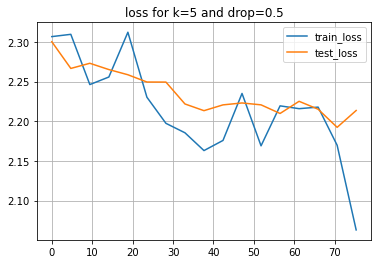

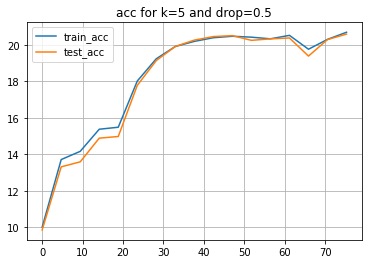

------ for k = 5 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Accuracy on the train set: 13.01%, Train Loss: 2.2920
Accuracy on the test set: 13.06%, Test Loss: 2.2009

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.36it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Accuracy on the train set: 31.83%, Train Loss: 1.8638
Accuracy on the test set: 30.71%, Test Loss: 1.9747

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Accuracy on the train set: 40.99%, Train Loss: 1.7695
Accuracy on the test set: 39.37%, Test Loss: 1.9196

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.05it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.91it/s]


Accuracy on the train set: 42.54%, Train Loss: 1.8483
Accuracy on the test set: 40.18%, Test Loss: 1.9096

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Accuracy on the train set: 45.44%, Train Loss: 1.8542
Accuracy on the test set: 43.22%, Test Loss: 1.8995

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.99it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Accuracy on the train set: 47.77%, Train Loss: 1.6897
Accuracy on the test set: 45.13%, Test Loss: 1.9013

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.92it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.76it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Accuracy on the train set: 47.28%, Train Loss: 1.8496
Accuracy on the test set: 44.73%, Test Loss: 1.9310

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.94it/s]


Accuracy on the train set: 48.00%, Train Loss: 1.8516
Accuracy on the test set: 44.96%, Test Loss: 1.9135

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.79it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Accuracy on the train set: 47.75%, Train Loss: 2.0003
Accuracy on the test set: 44.77%, Test Loss: 1.8995

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 48.31%, Train Loss: 1.6267
Accuracy on the test set: 45.35%, Test Loss: 1.9174

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.15it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Accuracy on the train set: 48.30%, Train Loss: 1.9319
Accuracy on the test set: 45.19%, Test Loss: 1.9247

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 48.46%, Train Loss: 1.7940
Accuracy on the test set: 44.88%, Test Loss: 1.9199

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.61it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Accuracy on the train set: 47.85%, Train Loss: 1.7663
Accuracy on the test set: 44.57%, Test Loss: 1.9063

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.62it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Accuracy on the train set: 48.42%, Train Loss: 1.9428
Accuracy on the test set: 44.94%, Test Loss: 1.9170

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.66it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 47.89%, Train Loss: 1.9449
Accuracy on the test set: 44.50%, Test Loss: 1.9697

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.72it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.84it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Accuracy on the train set: 48.12%, Train Loss: 1.7284
Accuracy on the test set: 44.56%, Test Loss: 1.9893

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Accuracy on the train set: 47.91%, Train Loss: 1.6362
Accuracy on the test set: 43.96%, Test Loss: 1.9485



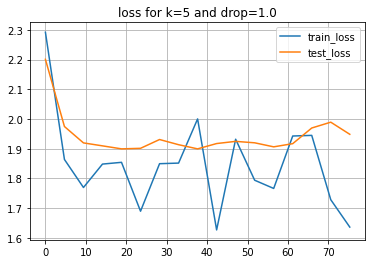

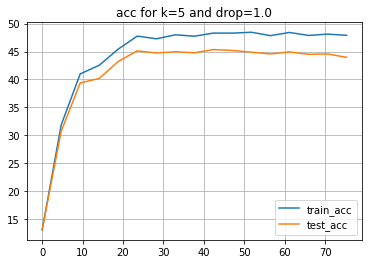

------ for k = 10 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.50it/s]


Accuracy on the train set: 10.04%, Train Loss: 2.3027
Accuracy on the test set: 9.88%, Test Loss: 2.3023

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Accuracy on the train set: 10.04%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.65it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.62it/s]


Accuracy on the train set: 10.06%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Accuracy on the train set: 10.07%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.84it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.03it/s]


Accuracy on the train set: 10.12%, Train Loss: 2.3026
Accuracy on the test set: 9.94%, Test Loss: 2.3026

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.55it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Accuracy on the train set: 10.07%, Train Loss: 2.3026
Accuracy on the test set: 9.89%, Test Loss: 2.3026

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.94it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.54it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.79it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.08it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.51it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.84it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.68it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.16it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Accuracy on the train set: 10.00%, Train Loss: 2.3026
Accuracy on the test set: 9.86%, Test Loss: 2.3026



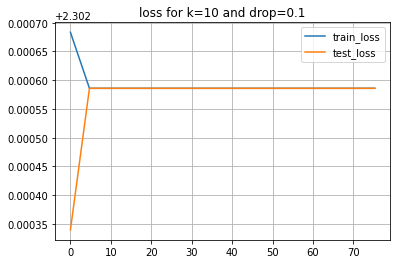

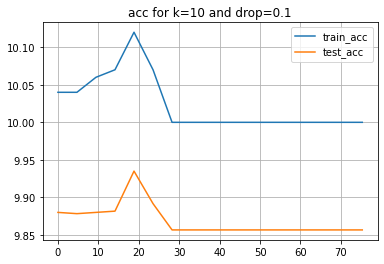

------ for k = 10 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.13it/s]


Accuracy on the train set: 14.53%, Train Loss: 2.2536
Accuracy on the test set: 14.41%, Test Loss: 2.2723

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Accuracy on the train set: 20.52%, Train Loss: 2.1064
Accuracy on the test set: 20.83%, Test Loss: 2.1703

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.07it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Accuracy on the train set: 25.02%, Train Loss: 2.0692
Accuracy on the test set: 25.10%, Test Loss: 2.1129

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.71it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.48it/s]


Accuracy on the train set: 34.70%, Train Loss: 2.0045
Accuracy on the test set: 34.24%, Test Loss: 2.0549

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.62it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.01it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.51it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Accuracy on the train set: 37.62%, Train Loss: 1.8871
Accuracy on the test set: 37.24%, Test Loss: 2.0098

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Accuracy on the train set: 39.82%, Train Loss: 1.9716
Accuracy on the test set: 39.02%, Test Loss: 2.0478

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.80it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Accuracy on the train set: 40.77%, Train Loss: 1.8833
Accuracy on the test set: 39.71%, Test Loss: 2.0029

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.58it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.47it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Accuracy on the train set: 41.94%, Train Loss: 1.9181
Accuracy on the test set: 40.65%, Test Loss: 1.9870

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.30it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.78it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Accuracy on the train set: 42.16%, Train Loss: 1.9794
Accuracy on the test set: 40.57%, Test Loss: 2.0221

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.81it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.72it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 40.32%, Train Loss: 2.0010
Accuracy on the test set: 37.90%, Test Loss: 2.0295

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.62it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Accuracy on the train set: 42.23%, Train Loss: 1.9210
Accuracy on the test set: 40.65%, Test Loss: 1.9823

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.56it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.47it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.98it/s]


Accuracy on the train set: 43.51%, Train Loss: 1.8343
Accuracy on the test set: 41.27%, Test Loss: 1.9730

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.87it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.62it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Accuracy on the train set: 43.65%, Train Loss: 1.6607
Accuracy on the test set: 41.43%, Test Loss: 1.9757

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.86it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Accuracy on the train set: 44.09%, Train Loss: 1.8111
Accuracy on the test set: 41.80%, Test Loss: 1.9697

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Accuracy on the train set: 43.84%, Train Loss: 1.8812
Accuracy on the test set: 41.13%, Test Loss: 1.9925

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.46it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.92it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Accuracy on the train set: 45.61%, Train Loss: 1.7984
Accuracy on the test set: 42.52%, Test Loss: 1.9790

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.04it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Accuracy on the train set: 46.62%, Train Loss: 1.9065
Accuracy on the test set: 43.80%, Test Loss: 1.9387



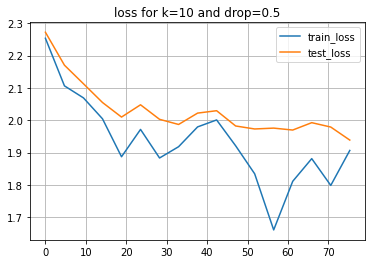

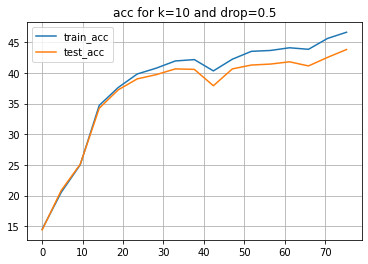

------ for k = 10 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Accuracy on the train set: 19.31%, Train Loss: 2.1358
Accuracy on the test set: 18.76%, Test Loss: 2.1366

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.24it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.01it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Accuracy on the train set: 48.62%, Train Loss: 1.7136
Accuracy on the test set: 47.10%, Test Loss: 1.8260

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.78it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.77it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Accuracy on the train set: 52.62%, Train Loss: 1.6599
Accuracy on the test set: 50.18%, Test Loss: 1.7389

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.36it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Accuracy on the train set: 54.00%, Train Loss: 1.7538
Accuracy on the test set: 51.02%, Test Loss: 1.6989

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.76it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.98it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.54it/s]


Accuracy on the train set: 54.97%, Train Loss: 1.6399
Accuracy on the test set: 51.74%, Test Loss: 1.7210

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Accuracy on the train set: 55.70%, Train Loss: 1.6010
Accuracy on the test set: 52.01%, Test Loss: 1.7485

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.45it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.54it/s]


Accuracy on the train set: 56.03%, Train Loss: 1.4547
Accuracy on the test set: 51.76%, Test Loss: 1.7546

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.80it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Accuracy on the train set: 55.99%, Train Loss: 1.2668
Accuracy on the test set: 51.34%, Test Loss: 1.7704

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.60it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.09it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Accuracy on the train set: 56.54%, Train Loss: 1.6693
Accuracy on the test set: 51.64%, Test Loss: 1.7498

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.88it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.54it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.73it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Accuracy on the train set: 56.82%, Train Loss: 1.3013
Accuracy on the test set: 51.51%, Test Loss: 1.7679

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 56.73%, Train Loss: 1.6044
Accuracy on the test set: 50.99%, Test Loss: 1.7739

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.63it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.13it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 56.81%, Train Loss: 1.4568
Accuracy on the test set: 51.02%, Test Loss: 1.8209

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.73it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Accuracy on the train set: 57.31%, Train Loss: 1.3621
Accuracy on the test set: 51.17%, Test Loss: 1.7898

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.66it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 57.07%, Train Loss: 1.4987
Accuracy on the test set: 50.41%, Test Loss: 1.8060

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.76it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.57it/s]


Accuracy on the train set: 57.82%, Train Loss: 1.4503
Accuracy on the test set: 50.83%, Test Loss: 1.8467

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.71it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Accuracy on the train set: 57.17%, Train Loss: 1.3936
Accuracy on the test set: 50.41%, Test Loss: 1.8439

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Accuracy on the train set: 57.44%, Train Loss: 1.4601
Accuracy on the test set: 50.72%, Test Loss: 1.8251



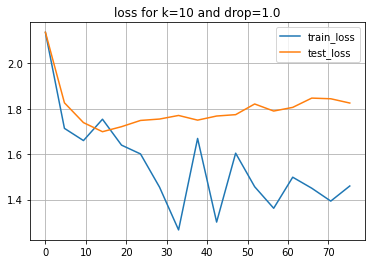

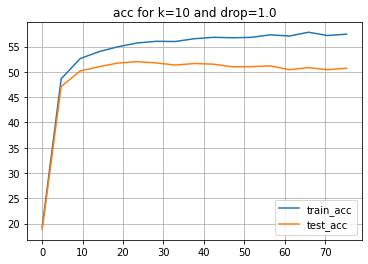

------ for k = 20 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Accuracy on the train set: 10.08%, Train Loss: 2.3026
Accuracy on the test set: 9.91%, Test Loss: 2.3057

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.77it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.50it/s]


Accuracy on the train set: 10.87%, Train Loss: 2.2982
Accuracy on the test set: 10.60%, Test Loss: 2.3064

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.59it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Accuracy on the train set: 10.09%, Train Loss: 2.2978
Accuracy on the test set: 9.87%, Test Loss: 2.3031

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 10.09%, Train Loss: 2.3024
Accuracy on the test set: 9.88%, Test Loss: 2.3031

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.90it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 10.16%, Train Loss: 2.3026
Accuracy on the test set: 9.93%, Test Loss: 2.3040

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Accuracy on the train set: 10.14%, Train Loss: 2.3029
Accuracy on the test set: 9.89%, Test Loss: 2.3032

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Accuracy on the train set: 10.13%, Train Loss: 2.3026
Accuracy on the test set: 9.92%, Test Loss: 2.3026

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.59it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.59it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 10.11%, Train Loss: 2.3026
Accuracy on the test set: 9.90%, Test Loss: 2.3026

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.62it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Accuracy on the train set: 10.14%, Train Loss: 2.3026
Accuracy on the test set: 9.93%, Test Loss: 2.3026

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.76it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Accuracy on the train set: 10.15%, Train Loss: 2.3026
Accuracy on the test set: 9.93%, Test Loss: 2.3026

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Accuracy on the train set: 10.14%, Train Loss: 2.3026
Accuracy on the test set: 9.94%, Test Loss: 2.3026

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 10.02%, Train Loss: 2.3026
Accuracy on the test set: 9.87%, Test Loss: 2.3026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.83it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Accuracy on the train set: 10.03%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.50it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.34it/s]


Accuracy on the train set: 10.13%, Train Loss: 2.3026
Accuracy on the test set: 9.90%, Test Loss: 2.3026

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.24it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.52it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 10.13%, Train Loss: 2.3026
Accuracy on the test set: 9.93%, Test Loss: 2.3026

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.81it/s]


Accuracy on the train set: 10.13%, Train Loss: 2.3010
Accuracy on the test set: 9.92%, Test Loss: 2.3026

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.99it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Accuracy on the train set: 10.07%, Train Loss: 2.3026
Accuracy on the test set: 9.88%, Test Loss: 2.3026



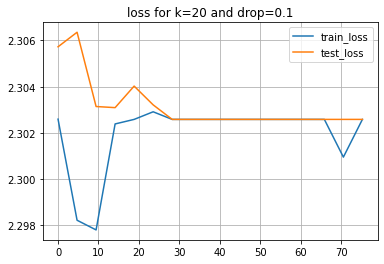

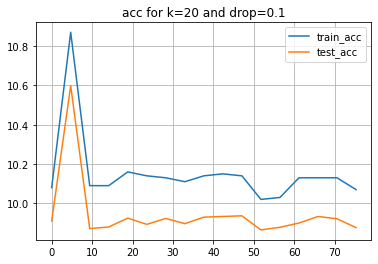

------ for k = 20 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Accuracy on the train set: 28.76%, Train Loss: 2.1915
Accuracy on the test set: 28.81%, Test Loss: 2.1376

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.81it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Accuracy on the train set: 45.68%, Train Loss: 1.9285
Accuracy on the test set: 44.78%, Test Loss: 1.9656

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Accuracy on the train set: 52.69%, Train Loss: 1.8032
Accuracy on the test set: 50.65%, Test Loss: 1.8710

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.33it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Accuracy on the train set: 54.49%, Train Loss: 1.7769
Accuracy on the test set: 52.26%, Test Loss: 1.8233

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.56it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Accuracy on the train set: 55.74%, Train Loss: 1.5803
Accuracy on the test set: 53.43%, Test Loss: 1.7728

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.75it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.91it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Accuracy on the train set: 56.12%, Train Loss: 1.6074
Accuracy on the test set: 53.44%, Test Loss: 1.7660

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Accuracy on the train set: 56.17%, Train Loss: 1.6813
Accuracy on the test set: 53.11%, Test Loss: 1.8309

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.61it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Accuracy on the train set: 56.32%, Train Loss: 1.8321
Accuracy on the test set: 53.16%, Test Loss: 1.7999

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.73it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.06it/s]


Accuracy on the train set: 56.64%, Train Loss: 1.7148
Accuracy on the test set: 53.22%, Test Loss: 1.7799

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Accuracy on the train set: 56.33%, Train Loss: 1.6960
Accuracy on the test set: 52.70%, Test Loss: 1.7744

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.26it/s]


Accuracy on the train set: 56.73%, Train Loss: 1.6024
Accuracy on the test set: 52.92%, Test Loss: 1.7690

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.97it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 56.86%, Train Loss: 1.4929
Accuracy on the test set: 53.04%, Test Loss: 1.7550

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.66it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.85it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.49it/s]


Accuracy on the train set: 57.01%, Train Loss: 1.5312
Accuracy on the test set: 52.75%, Test Loss: 1.7889

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Accuracy on the train set: 56.93%, Train Loss: 1.5330
Accuracy on the test set: 52.23%, Test Loss: 1.7905

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.68it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Accuracy on the train set: 56.71%, Train Loss: 1.6814
Accuracy on the test set: 52.37%, Test Loss: 1.8116

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.56it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Accuracy on the train set: 57.24%, Train Loss: 1.7106
Accuracy on the test set: 52.46%, Test Loss: 1.8112

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.68it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Accuracy on the train set: 57.12%, Train Loss: 1.6721
Accuracy on the test set: 52.55%, Test Loss: 1.7751



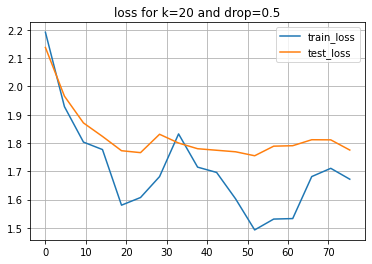

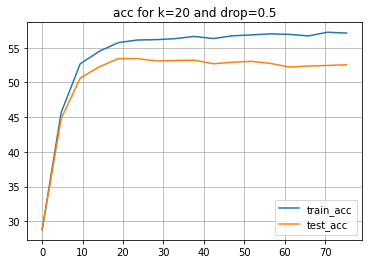

------ for k = 20 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Accuracy on the train set: 41.47%, Train Loss: 1.8702
Accuracy on the test set: 41.53%, Test Loss: 1.9550

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.85it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.09it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.79it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 54.00%, Train Loss: 1.6636
Accuracy on the test set: 51.95%, Test Loss: 1.8096

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.92it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Accuracy on the train set: 55.46%, Train Loss: 1.7022
Accuracy on the test set: 52.91%, Test Loss: 1.7949

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.65it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.70it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Accuracy on the train set: 56.72%, Train Loss: 1.4575
Accuracy on the test set: 53.15%, Test Loss: 1.7691

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Accuracy on the train set: 57.03%, Train Loss: 1.5220
Accuracy on the test set: 52.18%, Test Loss: 1.7317

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.61it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Accuracy on the train set: 57.87%, Train Loss: 1.5915
Accuracy on the test set: 52.55%, Test Loss: 1.7870

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.64it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.46it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.44it/s]


Accuracy on the train set: 58.69%, Train Loss: 1.3091
Accuracy on the test set: 52.20%, Test Loss: 1.8211

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.08it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.78it/s]


Accuracy on the train set: 59.08%, Train Loss: 1.3326
Accuracy on the test set: 51.67%, Test Loss: 1.8358

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Accuracy on the train set: 59.49%, Train Loss: 1.4184
Accuracy on the test set: 51.15%, Test Loss: 1.8483

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.51it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.46it/s]


Accuracy on the train set: 59.73%, Train Loss: 1.5312
Accuracy on the test set: 51.10%, Test Loss: 1.8634

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Accuracy on the train set: 60.26%, Train Loss: 1.6038
Accuracy on the test set: 50.39%, Test Loss: 1.8918

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.70it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.84it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.85it/s]


Accuracy on the train set: 60.54%, Train Loss: 1.2438
Accuracy on the test set: 50.19%, Test Loss: 1.9194

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.84it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Accuracy on the train set: 60.73%, Train Loss: 1.3906
Accuracy on the test set: 49.88%, Test Loss: 2.0446

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.99it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Accuracy on the train set: 61.82%, Train Loss: 1.4225
Accuracy on the test set: 49.81%, Test Loss: 2.0404

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.25it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Accuracy on the train set: 62.17%, Train Loss: 1.4083
Accuracy on the test set: 49.66%, Test Loss: 2.0836

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.42it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.90it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Accuracy on the train set: 61.84%, Train Loss: 1.2055
Accuracy on the test set: 49.13%, Test Loss: 2.0995

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.90it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Accuracy on the train set: 62.48%, Train Loss: 1.2163
Accuracy on the test set: 49.48%, Test Loss: 2.1652



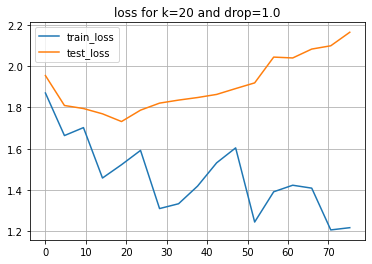

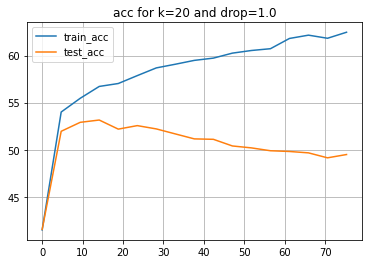

------ for k = 40 and dropout =  0.1 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Accuracy on the train set: 8.90%, Train Loss: 2.2916
Accuracy on the test set: 8.86%, Test Loss: 2.3080

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.68it/s]


Accuracy on the train set: 14.01%, Train Loss: 2.2900
Accuracy on the test set: 13.89%, Test Loss: 2.2758

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Accuracy on the train set: 13.81%, Train Loss: 2.2916
Accuracy on the test set: 13.66%, Test Loss: 2.2961

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.45it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.84it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Accuracy on the train set: 14.80%, Train Loss: 2.2898
Accuracy on the test set: 14.86%, Test Loss: 2.2911

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.73it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Accuracy on the train set: 15.95%, Train Loss: 2.2804
Accuracy on the test set: 15.81%, Test Loss: 2.2824

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.67it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Accuracy on the train set: 16.41%, Train Loss: 2.2868
Accuracy on the test set: 16.17%, Test Loss: 2.2842

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.16it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Accuracy on the train set: 15.90%, Train Loss: 2.2903
Accuracy on the test set: 15.54%, Test Loss: 2.2822

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.94it/s]


Accuracy on the train set: 17.58%, Train Loss: 2.2792
Accuracy on the test set: 17.17%, Test Loss: 2.2848

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.50it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.70it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.53it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Accuracy on the train set: 19.54%, Train Loss: 2.2736
Accuracy on the test set: 19.01%, Test Loss: 2.2774

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.58it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Accuracy on the train set: 19.96%, Train Loss: 2.2676
Accuracy on the test set: 19.43%, Test Loss: 2.2727

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.76it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.77it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Accuracy on the train set: 20.22%, Train Loss: 2.2810
Accuracy on the test set: 19.70%, Test Loss: 2.2825

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.80it/s]


Accuracy on the train set: 20.63%, Train Loss: 2.2737
Accuracy on the test set: 20.04%, Test Loss: 2.2713

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.17it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.08it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.45it/s]


Accuracy on the train set: 20.85%, Train Loss: 2.2653
Accuracy on the test set: 20.50%, Test Loss: 2.2649

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.74it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.41it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.77it/s]


Accuracy on the train set: 20.28%, Train Loss: 2.2796
Accuracy on the test set: 19.82%, Test Loss: 2.2775

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.76it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.94it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Accuracy on the train set: 20.63%, Train Loss: 2.2735
Accuracy on the test set: 20.35%, Test Loss: 2.2675

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.35it/s]


Accuracy on the train set: 20.44%, Train Loss: 2.2798
Accuracy on the test set: 19.93%, Test Loss: 2.2700

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.59it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.71it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.79it/s]


Accuracy on the train set: 20.68%, Train Loss: 2.2713
Accuracy on the test set: 20.32%, Test Loss: 2.2703



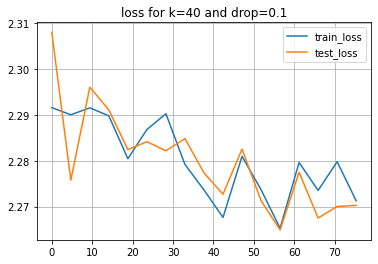

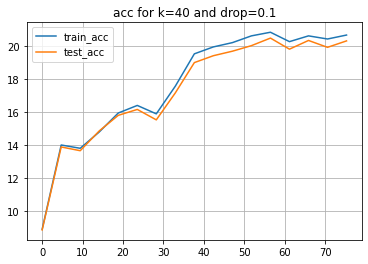

------ for k = 40 and dropout =  0.5 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.32it/s]


Accuracy on the train set: 33.91%, Train Loss: 2.1042
Accuracy on the test set: 34.23%, Test Loss: 2.1087

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.40it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.74it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.54it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.68it/s]


Accuracy on the train set: 53.33%, Train Loss: 1.6872
Accuracy on the test set: 51.98%, Test Loss: 1.8302

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.43it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.09it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.22it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Accuracy on the train set: 55.45%, Train Loss: 1.6708
Accuracy on the test set: 53.61%, Test Loss: 1.7787

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.45it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.68it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.73it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Accuracy on the train set: 55.96%, Train Loss: 1.6778
Accuracy on the test set: 53.59%, Test Loss: 1.7885

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.19it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.69it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.93it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.28it/s]


Accuracy on the train set: 56.61%, Train Loss: 1.5907
Accuracy on the test set: 53.97%, Test Loss: 1.7888

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.59it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.23it/s]


Accuracy on the train set: 57.60%, Train Loss: 1.5132
Accuracy on the test set: 54.38%, Test Loss: 1.7838

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.01it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Accuracy on the train set: 57.41%, Train Loss: 1.3665
Accuracy on the test set: 54.00%, Test Loss: 1.8208

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.60it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.07it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.26it/s]


Accuracy on the train set: 58.23%, Train Loss: 1.5873
Accuracy on the test set: 54.30%, Test Loss: 1.7265

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.55it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.29it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Accuracy on the train set: 58.48%, Train Loss: 1.4704
Accuracy on the test set: 54.27%, Test Loss: 1.7358

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.00it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.90it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.37it/s]


Accuracy on the train set: 58.87%, Train Loss: 1.5002
Accuracy on the test set: 54.34%, Test Loss: 1.7401

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.30it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.95it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.83it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.74it/s]


Accuracy on the train set: 59.11%, Train Loss: 1.3305
Accuracy on the test set: 54.22%, Test Loss: 1.7483

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.26it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.82it/s]


Accuracy on the train set: 59.27%, Train Loss: 1.5555
Accuracy on the test set: 53.95%, Test Loss: 1.7786

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.70it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.03it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.67it/s]


Accuracy on the train set: 59.48%, Train Loss: 1.6298
Accuracy on the test set: 53.80%, Test Loss: 1.7841

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.04it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.13it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.46it/s]


Accuracy on the train set: 59.98%, Train Loss: 1.3618
Accuracy on the test set: 54.13%, Test Loss: 1.7982

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.57it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.62it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Accuracy on the train set: 59.85%, Train Loss: 1.3775
Accuracy on the test set: 53.71%, Test Loss: 1.7982

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.86it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.34it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.12it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.83it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.87it/s]


Accuracy on the train set: 60.15%, Train Loss: 1.4562
Accuracy on the test set: 53.79%, Test Loss: 1.7933

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.75it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.38it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.40it/s]


Accuracy on the train set: 60.37%, Train Loss: 1.2493
Accuracy on the test set: 53.52%, Test Loss: 1.7798



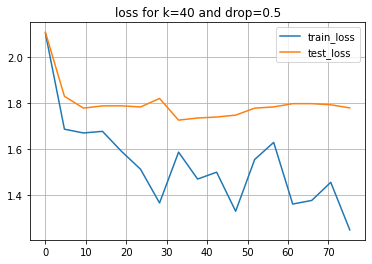

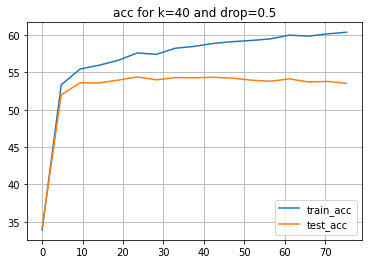

------ for k = 40 and dropout =  1.0 ---------
Epoch : [0/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Accuracy on the train set: 50.02%, Train Loss: 1.8161
Accuracy on the test set: 48.82%, Test Loss: 1.8098

Epoch : [1/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.49it/s]


Epoch : [2/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.55it/s]


Epoch : [3/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [4/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.93it/s]


Epoch : [5/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Accuracy on the train set: 55.62%, Train Loss: 1.7816
Accuracy on the test set: 52.83%, Test Loss: 1.7369

Epoch : [6/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.73it/s]


Epoch : [7/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.15it/s]


Epoch : [8/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.06it/s]


Epoch : [9/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [10/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.99it/s]


Accuracy on the train set: 58.16%, Train Loss: 1.3021
Accuracy on the test set: 53.74%, Test Loss: 1.6949

Epoch : [11/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.73it/s]


Epoch : [12/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.96it/s]


Epoch : [13/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.98it/s]


Epoch : [14/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.27it/s]


Epoch : [15/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.89it/s]


Accuracy on the train set: 59.77%, Train Loss: 1.2353
Accuracy on the test set: 53.47%, Test Loss: 1.6891

Epoch : [16/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Epoch : [17/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [18/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.35it/s]


Epoch : [19/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [20/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.38it/s]


Accuracy on the train set: 61.48%, Train Loss: 1.2637
Accuracy on the test set: 52.99%, Test Loss: 1.7388

Epoch : [21/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [22/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Epoch : [23/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.79it/s]


Epoch : [24/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Epoch : [25/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.11it/s]


Accuracy on the train set: 62.64%, Train Loss: 0.9543
Accuracy on the test set: 51.96%, Test Loss: 1.8168

Epoch : [26/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [27/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [28/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [29/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.79it/s]


Epoch : [30/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.07it/s]


Accuracy on the train set: 63.88%, Train Loss: 0.9462
Accuracy on the test set: 51.15%, Test Loss: 1.7529

Epoch : [31/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.47it/s]


Epoch : [32/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.48it/s]


Epoch : [33/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.50it/s]


Epoch : [34/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.67it/s]


Epoch : [35/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Accuracy on the train set: 65.15%, Train Loss: 1.1545
Accuracy on the test set: 50.81%, Test Loss: 1.8016

Epoch : [36/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.30it/s]


Epoch : [37/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [38/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.97it/s]


Epoch : [39/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.38it/s]


Epoch : [40/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.28it/s]


Accuracy on the train set: 66.34%, Train Loss: 1.0769
Accuracy on the test set: 49.47%, Test Loss: 1.8907

Epoch : [41/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.95it/s]


Epoch : [42/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.59it/s]


Epoch : [43/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.70it/s]


Epoch : [44/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.33it/s]


Epoch : [45/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.67it/s]


Accuracy on the train set: 67.43%, Train Loss: 0.9948
Accuracy on the test set: 49.49%, Test Loss: 1.9611

Epoch : [46/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.81it/s]


Epoch : [47/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Epoch : [48/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.18it/s]


Epoch : [49/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.27it/s]


Epoch : [50/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.27it/s]


Accuracy on the train set: 68.56%, Train Loss: 0.9545
Accuracy on the test set: 49.46%, Test Loss: 2.0171

Epoch : [51/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [52/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.92it/s]


Epoch : [53/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.12it/s]


Epoch : [54/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.25it/s]


Epoch : [55/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.78it/s]


Accuracy on the train set: 69.97%, Train Loss: 0.9022
Accuracy on the test set: 49.08%, Test Loss: 2.1026

Epoch : [56/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.31it/s]


Epoch : [57/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.73it/s]


Epoch : [58/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.20it/s]


Epoch : [59/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.00it/s]


Epoch : [60/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.77it/s]


Accuracy on the train set: 70.80%, Train Loss: 0.9321
Accuracy on the test set: 48.81%, Test Loss: 2.1433

Epoch : [61/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.36it/s]


Epoch : [62/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.88it/s]


Epoch : [63/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.21it/s]


Epoch : [64/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.72it/s]


Epoch : [65/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.50it/s]


Accuracy on the train set: 72.56%, Train Loss: 0.8630
Accuracy on the test set: 47.98%, Test Loss: 2.2423

Epoch : [66/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [67/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.39it/s]


Epoch : [68/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.32it/s]


Epoch : [69/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.14it/s]


Epoch : [70/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.51it/s]


Accuracy on the train set: 73.16%, Train Loss: 0.9269
Accuracy on the test set: 47.96%, Test Loss: 2.3300

Epoch : [71/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.24it/s]


Epoch : [72/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.85it/s]


Epoch : [73/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.65it/s]


Epoch : [74/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.53it/s]


Epoch : [75/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.10it/s]


Accuracy on the train set: 74.38%, Train Loss: 0.9201
Accuracy on the test set: 47.73%, Test Loss: 2.3852

Epoch : [76/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [77/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.38it/s]


Epoch : [78/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.69it/s]


Epoch : [79/80]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.74it/s]


Accuracy on the train set: 74.49%, Train Loss: 0.7271
Accuracy on the test set: 48.26%, Test Loss: 2.4511



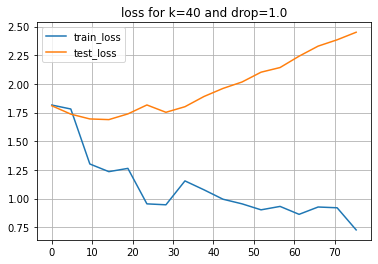

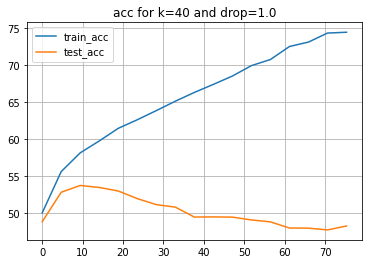

In [24]:
records = []

for k in [1,5,10,20,40]:
    for dropout_prob in [0.1, 0.5, 1.0]:

        print (f'------ for k = {k} and dropout =  {dropout_prob} ---------')
        train_loss, test_loss, train_acc, test_acc = train_loop(train_dataloader, 
                                                                test_dataloader, 
                                                                n_epochs=num_epochs, 
                                                                k=k, 
                                                                dropout_prob=1-dropout_prob, 
                                                                lr=0.001)
        
        plot_list(train_loss,'train_loss', test_loss,'test_loss', f'loss for k={k} and drop={dropout_prob}')
        plot_list(train_acc,'train_acc', test_acc,'test_acc', f'acc for k={k} and drop={dropout_prob}')

        records.append({
            'k':k,
            'dropout_prob':dropout_prob,
            'train_loss':train_loss, 
            'test_loss': test_loss, 
            'train_acc': train_acc, 
            'test_acc': test_acc
        })

In [25]:
records_updated = []

for record in records:
    records_updated.append({
            'k':record['k'],
            'dropout_prob':record['dropout_prob'],
            'train_acc': max(record['train_acc']), 
            'test_acc': max(record['test_acc']), 
        })
df = pd.DataFrame.from_records(records_updated)

print (df)
df_tensor = torch.tensor(df.values)

     k  dropout_prob  train_acc   test_acc
0    1           0.1      10.00   9.853333
1    1           0.5      10.00   9.853333
2    1           1.0      15.16  14.856667
3    5           0.1      10.05   9.901667
4    5           0.5      20.68  20.578333
5    5           1.0      48.46  45.355000
6   10           0.1      10.12   9.935000
7   10           0.5      46.62  43.801667
8   10           1.0      57.82  52.011667
9   20           0.1      10.87  10.598333
10  20           0.5      57.24  53.443333
11  20           1.0      62.48  53.150000
12  40           0.1      20.85  20.495000
13  40           0.5      60.37  54.385000
14  40           1.0      74.49  53.743333


[]

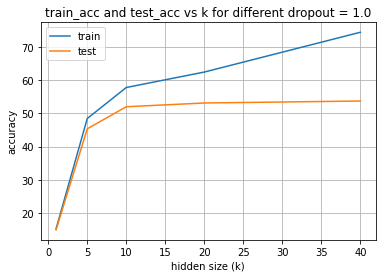

In [26]:
plt.figure(1)
sub_df = df_tensor[df_tensor[:,1] == 1.0]
plt.plot(sub_df[:, 0], sub_df[:,2], label='train')
plt.plot(sub_df[:, 0], sub_df[:,3], label='test')

plt.title('train_acc and test_acc vs k for different dropout = 1.0')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()

As k increases, the accuracy and performance of the model increases and improves.
AS we have noisy data, we can not have 100% accuracy.
However, as 60% of the data is true, so we should have around 60% accuracy and we can get that k = 20

[]

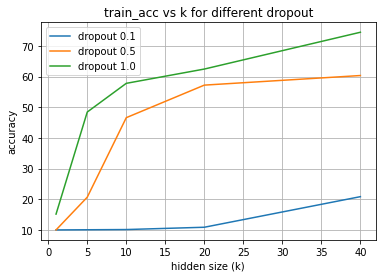

In [27]:
plt.figure(2)
for p in [0.1,0.5, 1.0]:
    sub_df = df_tensor[df_tensor[:,1] == p]
    plt.plot(sub_df[:, 0], sub_df[:,2], label=f'dropout {p}')

plt.title('train_acc vs k for different dropout')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()

The value of p or dropout helps the model generalize and prevents overfitting.

As we increase the value of p, we can see that the model improves and also it is easier to optimize.

At p = 1 we can see 60% train accuracy at k = 20.

At p = 0.5 we can see 60% train accuracy at k = 40.

At p = 0.1 we can see 60% train accuracy at k = 80 if we had run our model for that many hidden units.

[]

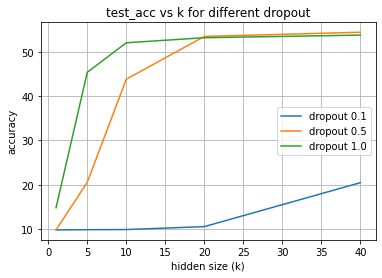

In [28]:
plt.figure(2)
for p in [0.1,0.5, 1.0]:
    sub_df = df_tensor[df_tensor[:,1] == p]
    plt.plot(sub_df[:, 0], sub_df[:,3], label=f'dropout {p}')

plt.title('test_acc vs k for different dropout')
plt.legend()
plt.xlabel('hidden size (k)')
plt.ylabel('accuracy')
plt.grid()
plt.plot()

We can see a little improvement in test accuracy when we add dropout.

The model converges earlier.

For k = 40 and dropout = 1.0, we can get the best test accuracy

--------------------------------------------

Noise adds random datapoints with incorrect labels and thus makes it hard for the model to learn the correct representation of the dataset.

Here we can see that adding 40% noise lowers the accuracy drastically and the best accuracy we can achieve is 63%.

However, we can see that dropout is more helpful in the noisy scenario as the model converges earlier.